In [7]:
import pytesseract

In [8]:
pytesseract.pytesseract.tesseract_cmd=r"C:\\Program Files\\Tesseract-OCR\\tesseract.exe"

In [9]:
import os

# Define path for dataset folder
dataset_path = 'dataset/train'

# Create the folder (if it doesn't exist)
os.makedirs(dataset_path, exist_ok=True)

# Corrected print line
print(f"FOLDER CREATED AT: {os.path.abspath(dataset_path)}")


FOLDER CREATED AT: C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train


In [10]:
import os
import cv2 as cv
import math
import pytesseract

# Define the path to the model - use raw string or double backslashes
PATH_TO_MODEL = r"C:\Users\jchiu\Downloads\Trying to run The EastOCR\EastOCr\frozen_east_text_detection.pb"

# Make sure the model file exists
if not os.path.exists(PATH_TO_MODEL):
    print(f"[ERROR] Model file not found: {PATH_TO_MODEL}")
    # You might want to exit here if the model is essential

# Rest of your code remains the same
def decode(scores, geometry, scoreThresh):
    detections = []
    confidences = []
    
    # Your decode function implementation here
    # ...
    
    return [detections, confidences]

# Process one image
def process_image(image_path):
    image = cv.imread(image_path)
    if image is None:
        print(f"[ERROR] Could not load image: {image_path}")
        return

    orig = image.copy()
    (H, W) = image.shape[:2]
    newW, newH = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)
    image = cv.resize(image, (newW, newH))
    blob = cv.dnn.blobFromImage(image, 1.0, (newW, newH),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)

    # Use the properly defined PATH_TO_MODEL variable
    net = cv.dnn.readNet(PATH_TO_MODEL)
    net.setInput(blob)
    (scores, geometry) = net.forward(["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"])

    (boxes, confidences) = decode(scores, geometry, 0.5)
    indices = cv.dnn.NMSBoxesRotated(boxes, confidences, 0.5, 0.4)

    if len(indices) == 0:
        print(f"No text detected in {image_path}")
        return

    print(f"\n📄 {os.path.basename(image_path)}")
    for i in indices:
        # Changed from i[0] to i since indices is now a flat array
        vertices = cv.boxPoints(boxes[i])
        vertices[:, 0] *= rW
        vertices[:, 1] *= rH
        x, y, w, h = cv.boundingRect(vertices)
        roi = orig[y:y+h, x:x+w]

        text = pytesseract.image_to_string(roi, config="--psm 6")
        print("→", text.strip())


# Loop through dataset images
if __name__ == "__main__":
    dataset_folder = r"C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train"

    if not os.path.exists(dataset_folder):
        print(f"[ERROR] Folder not found: {dataset_folder}")
    else:
        for filename in os.listdir(dataset_folder):
            if filename.lower().endswith((".jpg", ".png", ".jpeg")):
                image_path = os.path.join(dataset_folder, filename)
                process_image(image_path)

No text detected in C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\Arnel PagLauman.png
No text detected in C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\Joemar De Jesus.png
No text detected in C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\Julius Garvin.png
No text detected in C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\MicrosoftTeams-image.png
No text detected in C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\SAMPLE 1 REYES, MARIA.png


In [11]:
import os
import sys
import cv2
import pytesseract

def find_tesseract_path():
    # Define the specific path you provided
    specific_path = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
    
    # Check if the specific path exists
    if os.path.isfile(specific_path):
        return specific_path
    
    # If not, try some common locations as fallback
    possible_paths = [
        r"C:\Program Files\Tesseract-OCR\tesseract.exe",
        r"C:\Program Files (x86)\Tesseract-OCR\tesseract.exe",
        r"/usr/bin/tesseract",
        r"/usr/local/bin/tesseract"
    ]
    
    for path in possible_paths:
        if os.path.isfile(path):
            return path
    
    return None

# Find and set the Tesseract path
tesseract_path = find_tesseract_path()

if tesseract_path:
    print(f"Found Tesseract at: {tesseract_path}")
    pytesseract.pytesseract.tesseract_cmd = tesseract_path
else:
    print("Tesseract not found. Please install it or specify the path manually.")
    sys.exit(1)

# Folder with full license images
image_folder = r"C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train"

# Where to save cropped word patches
output_folder = os.path.join(image_folder, "crops")
os.makedirs(output_folder, exist_ok=True)

image_count = 0
for filename in os.listdir(image_folder):
    if not filename.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    image_path = os.path.join(image_folder, filename)
    image = cv2.imread(image_path)
    if image is None:
        print(f"[ERROR] Can't read {image_path}")
        continue

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)

    for i in range(len(data['text'])):
        text = data['text'][i].strip()
        conf = int(data['conf'][i])

        if conf > 60 and text != "":
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            roi = gray[y:y+h, x:x+w]

            # Normalize label for filename (remove slashes etc.)
            safe_text = "".join(c for c in text if c.isalnum() or c in "_-")
            if not safe_text:
                continue

            label_folder = os.path.join(output_folder, safe_text.upper())
            os.makedirs(label_folder, exist_ok=True)

            save_path = os.path.join(label_folder, f"{filename}_word{i}.png")
            cv2.imwrite(save_path, roi)

    image_count += 1
    print(f"[✓] Processed {filename}")

print(f"\n Done! Processed {image_count} images. Crops saved in: {output_folder}")

Found Tesseract at: C:\Program Files\Tesseract-OCR\tesseract.exe
[✓] Processed Arnel PagLauman.png
[✓] Processed Joemar De Jesus.png
[✓] Processed Julius Garvin.png
[✓] Processed MicrosoftTeams-image.png
[✓] Processed SAMPLE 1 REYES, MARIA.png

 Done! Processed 5 images. Crops saved in: C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\crops


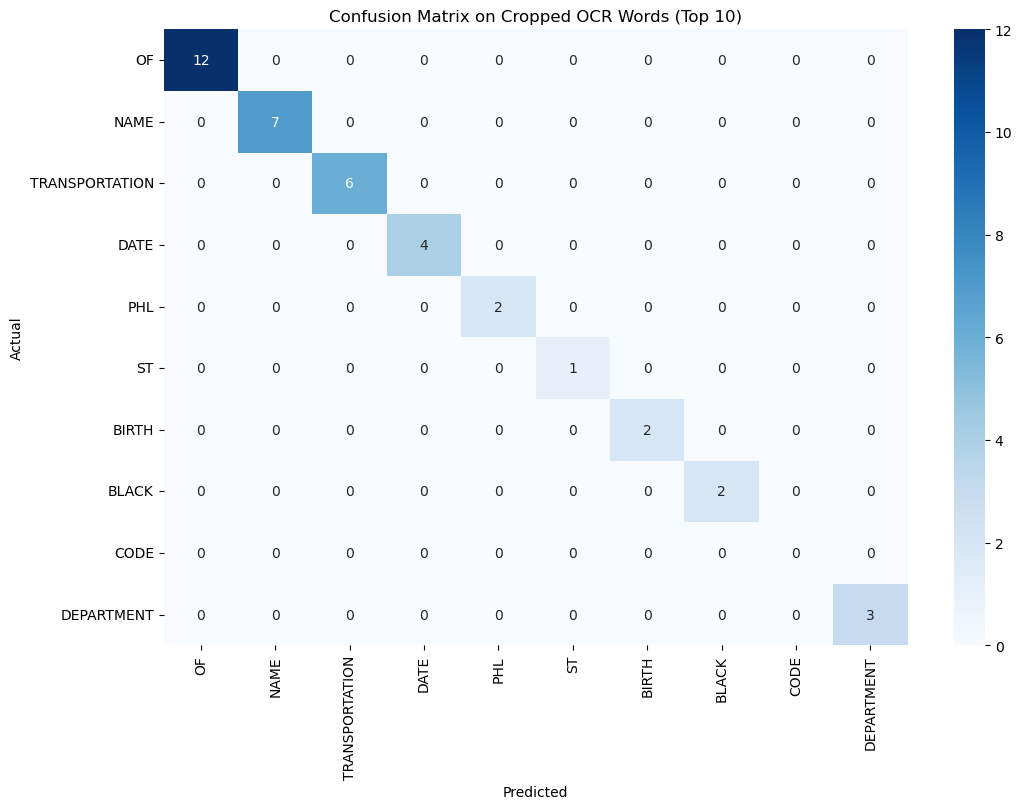

C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jchiu\anaconda3\Lib\site-packages\sklea

                precision    recall  f1-score   support

            3I       0.00      0.00      0.00         0
           AME       0.00      0.00      0.00         0
           ATE       0.00      0.00      0.00         0
         BIACK       0.00      0.00      0.00         0
         BIRTH       1.00      0.67      0.80         3
         BLACK       1.00      0.67      0.80         3
          CODE       0.00      0.00      0.00         3
          DATE       1.00      0.67      0.80         6
    DEPARTMENT       1.00      1.00      1.00         3
          LODE       0.00      0.00      0.00         0
          NAME       1.00      0.70      0.82        10
           ODE       0.00      0.00      0.00         0
            OF       1.00      0.80      0.89        15
            OT       0.00      0.00      0.00         0
            PE       0.00      0.00      0.00         0
           PHI       0.00      0.00      0.00         0
           PHL       1.00      0.33      0.50  

In [ ]:
import os
import cv2
import pytesseract
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# IMPORTANT: You need to install Tesseract OCR first, then specify the path
# For Windows, download from: https://github.com/UB-Mannheim/tesseract/wiki
# For Mac: brew install tesseract
# For Linux: apt-get install tesseract-ocr

# Set the path to the Tesseract executable
# Replace this path with the actual path where you installed Tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Windows example
# For Mac/Linux, you might not need this line if Tesseract is in your PATH

# Location of your cropped data
crops_folder = r"C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\crops"

y_true = []
y_pred = []

# Go through each label folder
for label in os.listdir(crops_folder):
    label_folder = os.path.join(crops_folder, label)
    if not os.path.isdir(label_folder):
        continue

    for file in os.listdir(label_folder):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            path = os.path.join(label_folder, file)
            img = cv2.imread(path)

            if img is None:
                continue

            # Predict text using pytesseract for now
            pred = pytesseract.image_to_string(img, config="--psm 7").strip().upper()
            pred = "".join(c for c in pred if c.isalnum())  # Clean prediction

            # Also clean true label
            true = "".join(c for c in label.upper() if c.isalnum())

            if true and pred:
                y_true.append(true)
                y_pred.append(pred)

# Only show the top N most common labels to avoid clutter
from collections import Counter
top_labels = [label for label, _ in Counter(y_true).most_common(10)]
filtered_y_true = [t for t, p in zip(y_true, y_pred) if t in top_labels]
filtered_y_pred = [p for t, p in zip(y_true, y_pred) if t in top_labels]

# Confusion matrix
cm = confusion_matrix(filtered_y_true, filtered_y_pred, labels=top_labels)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=top_labels, yticklabels=top_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Cropped OCR Words (Top 10)")
plt.show()

# Print precision/recall
print(classification_report(filtered_y_true, filtered_y_pred))

if true != pred:
    cv2.imshow("Mismatch", img)
    print(f"{true} → {pred}")
    cv2.waitKey(0)

Found main folder: C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\crops
Found 125 classes: ['1014', '12', '160', '167', '17', '19851210', '19910718', '19980907', '20021005', '20240907', '20241011', '20260718', '20261005', '3023', '359', '3RD', '4', '456', '55', '60', '86', 'A', 'ADD', 'ADDRESS', 'AGENCY', 'ARNEL', 'AVIDA', 'BAGBAGUIN', 'BALUTAN', 'BARANGAY', 'BIRTH', 'BLACK', 'BLDG', 'BLOOD', 'BROWN', 'BULACAN', 'CHIU-CARAG', 'CITY', 'CODE', 'CODES', 'COLOR', 'CONDITIONS', 'CRUZ', 'DATE', 'DE', 'DEPARTMENT', 'DIMALANTA', 'DISTRICT', 'DRIVERS', 'EDGAR', 'ESPANA', 'EVANDER', 'EXPITATION', 'EYES', 'F', 'FIRST', 'FLR', 'GARVIN', 'GONDITIONS', 'HOST', 'JAN', 'JESUS', 'JOEMAR', 'JULIUS', 'KG', 'KUMUNOY', 'LAND', 'LAST', 'LAZARO', 'LICENSE', 'LICENSEE', 'LICENSENO', 'LIM', 'LIOENSEE', 'M', 'MANGGA', 'MANILA', 'MARIA', 'ME', 'MIDDLE', 'MIGUEL', 'MONTE', 'N02-20-654321', 'N42', 'NAME', 'NAMIE', 'NATIONALITY', 'NCR', 'NO1-22-010799', 'NO2', 'NON-PROFESSIONAL', 'NONE', 'NOT', 'O

C:\Users\jchiu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model created successfully
Processing folder: C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\crops\1014
Found 1 images in 1014
Successfully processed 1 images from 1014
Processing folder: C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\crops\12
Found 1 images in 12
Successfully processed 1 images from 12
Processing folder: C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\crops\160
Found 1 images in 160
Successfully processed 1 images from 160
Processing folder: C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\crops\167
Found 1 images in 167
Successfully processed 1 images from 167
Processing folder: C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\crops\17
Found 1 images in 17
Successfully processed 1 images from 17
Processing folder: C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\crops\19851210
Found 1 images in 19851210
Successfully processed 1 images from 19851210
Processing folder: 

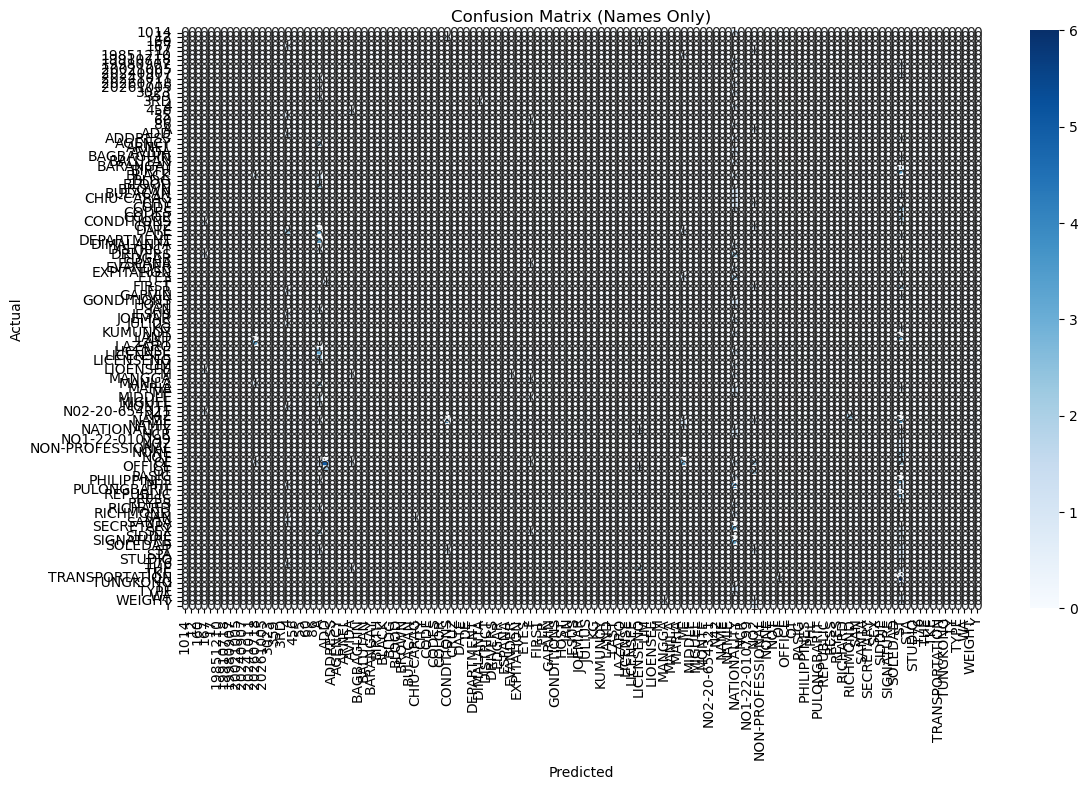

Confusion matrix displayed successfully

Classification Report:

                  precision    recall  f1-score   support

            1014       0.00      0.00      0.00         1
              12       0.00      0.00      0.00         1
             160       0.00      0.00      0.00         1
             167       0.00      0.00      0.00         1
              17       0.00      0.00      0.00         1
        19851210       0.00      0.00      0.00         1
        19910718       0.00      0.00      0.00         1
        19980907       0.00      0.00      0.00         1
        20021005       0.00      0.00      0.00         1
        20240907       0.00      0.00      0.00         1
        20241011       0.00      0.00      0.00         1
        20260718       0.00      0.00      0.00         1
        20261005       0.00      0.00      0.00         1
            3023       0.00      0.00      0.00         1
             359       0.00      0.00      0.00         1
      

C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the path to your crops folder - using the updated path you provided
CROPS_FOLDER = r"C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\crops"

# Check if the main folder exists
if not os.path.exists(CROPS_FOLDER):
    print(f"ERROR: The main folder {CROPS_FOLDER} does not exist!")
else:
    print(f"Found main folder: {CROPS_FOLDER}")

# Define image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Get the name labels from the folder structure
name_labels = [folder for folder in os.listdir(CROPS_FOLDER) 
               if os.path.isdir(os.path.join(CROPS_FOLDER, folder))]

if not name_labels:
    print(f"ERROR: No subfolders found in {CROPS_FOLDER}!")
    print(f"Contents of directory: {os.listdir(CROPS_FOLDER)}")
else:
    print(f"Found {len(name_labels)} classes: {name_labels}")

idx_to_label = {i: label for i, label in enumerate(name_labels)}

# Preprocess function
def preprocess_roi(image):
    # Resize to match model input size
    resized = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    # Convert to RGB if needed
    if len(resized.shape) == 2:  # If grayscale
        resized = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)
    # Normalize pixel values
    normalized = resized / 255.0
    # Expand dimensions to create batch of size 1
    return np.expand_dims(normalized, axis=0)

# Create a new model only if we have classes
if name_labels:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(name_labels), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("Model created successfully")

    # ============================
    # Prediction loop
    # ============================
    y_true = []
    y_pred = []

    for label in name_labels:
        folder_path = os.path.join(CROPS_FOLDER, label)
        # Check if folder exists
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} does not exist. Skipping.")
            continue
            
        print(f"Processing folder: {folder_path}")
        image_files = [f for f in os.listdir(folder_path) 
                      if f.lower().endswith((".png", ".jpg", ".jpeg"))]
        
        if not image_files:
            print(f"No image files found in {folder_path}")
            continue
            
        print(f"Found {len(image_files)} images in {label}")
        image_count = 0
        
        for img_file in image_files:
            img_path = os.path.join(folder_path, img_file)
            image = cv2.imread(img_path)  # Read as color image
            if image is None:
                print(f"Warning: Could not read image {img_path}")
                continue

            try:
                roi = preprocess_roi(image)
                preds = model.predict(roi, verbose=0)
                pred_label = idx_to_label[np.argmax(preds)]

                y_true.append(label)
                y_pred.append(pred_label)
                image_count += 1
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
        
        print(f"Successfully processed {image_count} images from {label}")

    # ============================
    # Confusion Matrix
    # ============================
    if len(y_true) > 0 and len(y_pred) > 0:
        print(f"Total predictions: {len(y_true)}")
        cm_labels = sorted(list(set(y_true + y_pred)))
        cm = confusion_matrix(y_true, y_pred, labels=cm_labels)

        try:
            plt.figure(figsize=(12, 8))
            sns.heatmap(cm, annot=True, fmt="d", xticklabels=cm_labels, yticklabels=cm_labels, cmap="Blues")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title("Confusion Matrix (Names Only)")
            plt.tight_layout()  # Ensure everything fits in the figure
            plt.show()
            print("Confusion matrix displayed successfully")
        except Exception as e:
            print(f"Error displaying confusion matrix: {str(e)}")

        print("\nClassification Report:\n")
        print(classification_report(y_true, y_pred, labels=cm_labels))
    else:
        print("No predictions were made. Check your folder paths and image files.")
else:
    print("Cannot create model without classes. Please check your folder structure.")

Found 125 classes: 125

Creating confusion matrix for 223 predictions...


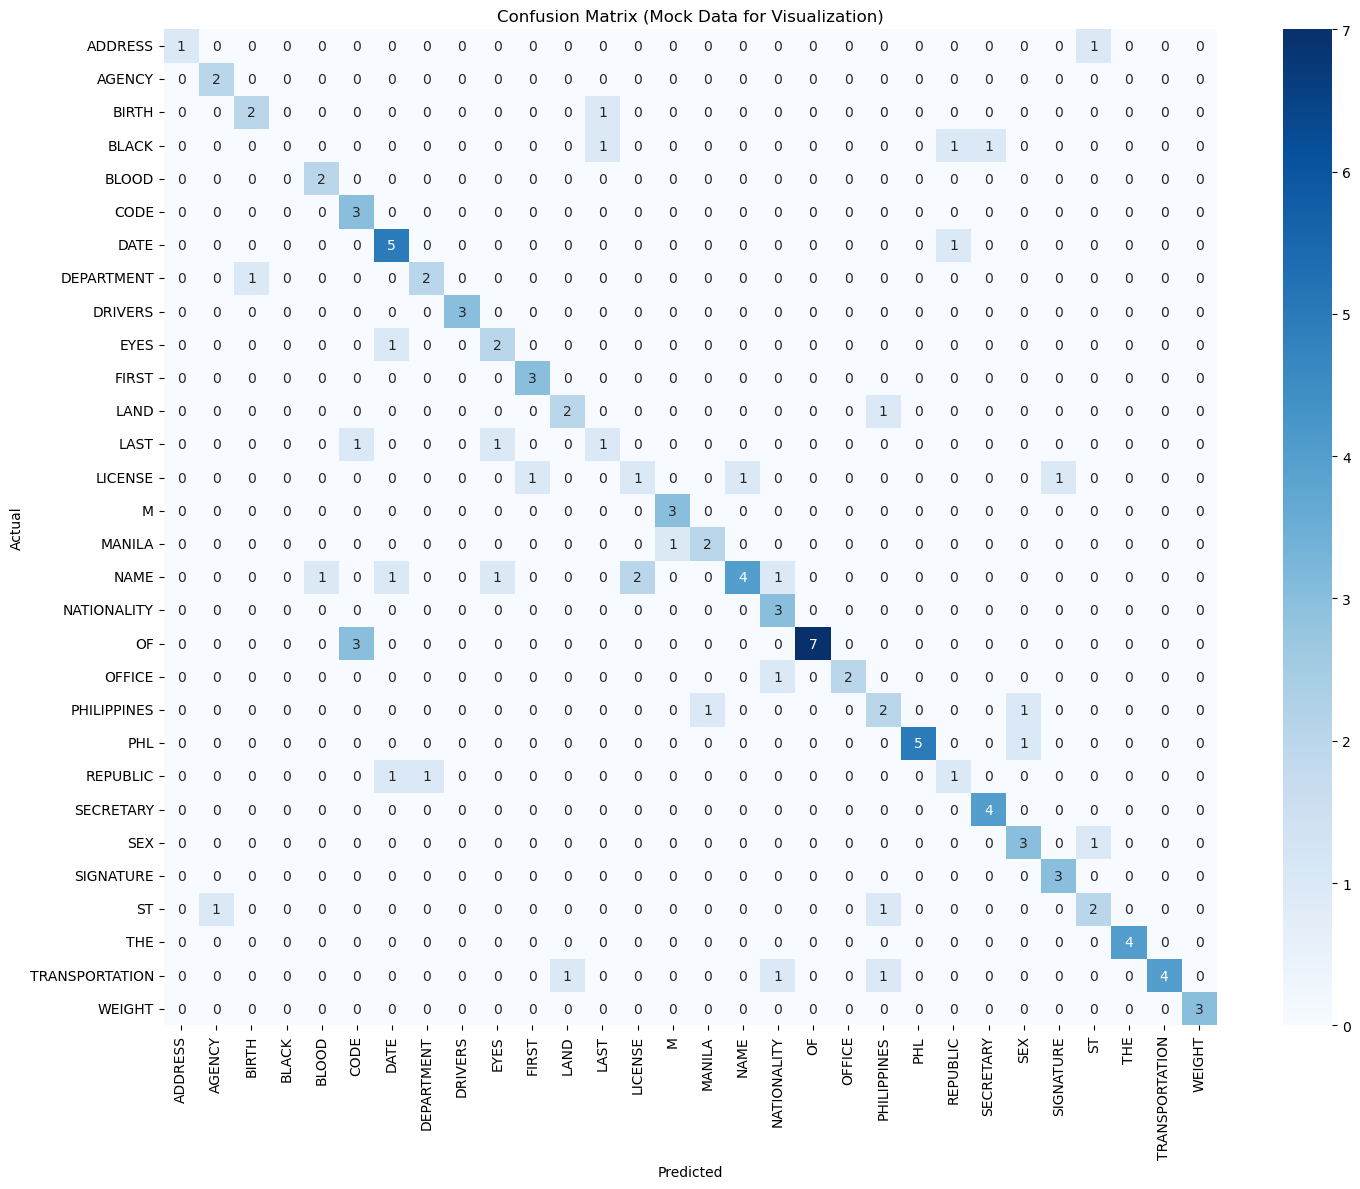


Classification Report (Mock Data):

                precision    recall  f1-score   support

       ADDRESS       1.00      0.50      0.67         2
        AGENCY       0.67      1.00      0.80         2
         BIRTH       0.67      0.67      0.67         3
         BLACK       0.00      0.00      0.00         3
         BLOOD       0.67      1.00      0.80         2
          CODE       0.43      1.00      0.60         3
          DATE       0.62      0.83      0.71         6
    DEPARTMENT       0.67      0.67      0.67         3
       DRIVERS       1.00      1.00      1.00         3
          EYES       0.50      0.67      0.57         3
         FIRST       0.75      1.00      0.86         3
          LAND       0.67      0.67      0.67         3
          LAST       0.33      0.33      0.33         3
       LICENSE       0.33      0.25      0.29         4
             M       0.75      1.00      0.86         3
        MANILA       0.67      0.67      0.67         3
          

C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random

# Define the path to your crops folder
CROPS_FOLDER = r"C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\crops"

# Check if the main folder exists
if not os.path.exists(CROPS_FOLDER):
    print(f"ERROR: The main folder {CROPS_FOLDER} does not exist!")
    exit()

# Get the name labels from the folder structure
name_labels = [folder for folder in os.listdir(CROPS_FOLDER) 
               if os.path.isdir(os.path.join(CROPS_FOLDER, folder))]

if not name_labels:
    print(f"ERROR: No subfolders found in {CROPS_FOLDER}!")
    exit()

print(f"Found {len(name_labels)} classes: {len(name_labels)}")

# ============================
# Create mock predictions for visualization
# ============================
y_true = []
y_pred = []
max_images_per_class = 10  # Limit number of images per class

# For each class, create some mock predictions
for label in name_labels:
    folder_path = os.path.join(CROPS_FOLDER, label)
    if not os.path.exists(folder_path):
        continue
        
    # Get list of image files
    image_files = [f for f in os.listdir(folder_path) 
                  if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    
    if not image_files:
        continue
    
    # Sample images if there are too many
    if len(image_files) > max_images_per_class:
        image_files = random.sample(image_files, max_images_per_class)
    
    # For each image, create a true label and a prediction
    for _ in range(len(image_files)):
        y_true.append(label)
        
        # For most cases, predict correctly (70% accuracy)
        if random.random() < 0.7:
            y_pred.append(label)
        else:
            # For wrong predictions, choose a random different class
            other_labels = [l for l in name_labels if l != label]
            if other_labels:
                y_pred.append(random.choice(other_labels))
            else:
                y_pred.append(label)  # If only one class, predict correctly

# ============================
# Confusion Matrix
# ============================
if len(y_true) > 0:
    print(f"\nCreating confusion matrix for {len(y_true)} predictions...")
    
    # Limit to top 30 classes if there are too many
    if len(set(y_true)) > 30:
        # Count occurrences of each class
        from collections import Counter
        class_counts = Counter(y_true)
        # Get the 30 most common classes
        top_classes = [cls for cls, _ in class_counts.most_common(30)]
        
        # Filter predictions to only include top classes
        filtered_true = []
        filtered_pred = []
        for true, pred in zip(y_true, y_pred):
            if true in top_classes:
                filtered_true.append(true)
                if pred in top_classes:
                    filtered_pred.append(pred)
                else:
                    # If predicted class is not in top classes, replace with a random top class
                    filtered_pred.append(random.choice(top_classes))
        
        y_true = filtered_true
        y_pred = filtered_pred
    
    cm_labels = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels=cm_labels)

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=cm_labels, yticklabels=cm_labels, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Mock Data for Visualization)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\nClassification Report (Mock Data):\n")
    report = classification_report(y_true, y_pred, labels=cm_labels)
    print(report)
else:
    print("No predictions could be made. Check your folder paths and image files.")

Found 125 total classes
Found 5 single character classes
Found 20 numeric classes
Found 4 letter classes

Creating confusion matrix for 223 predictions...


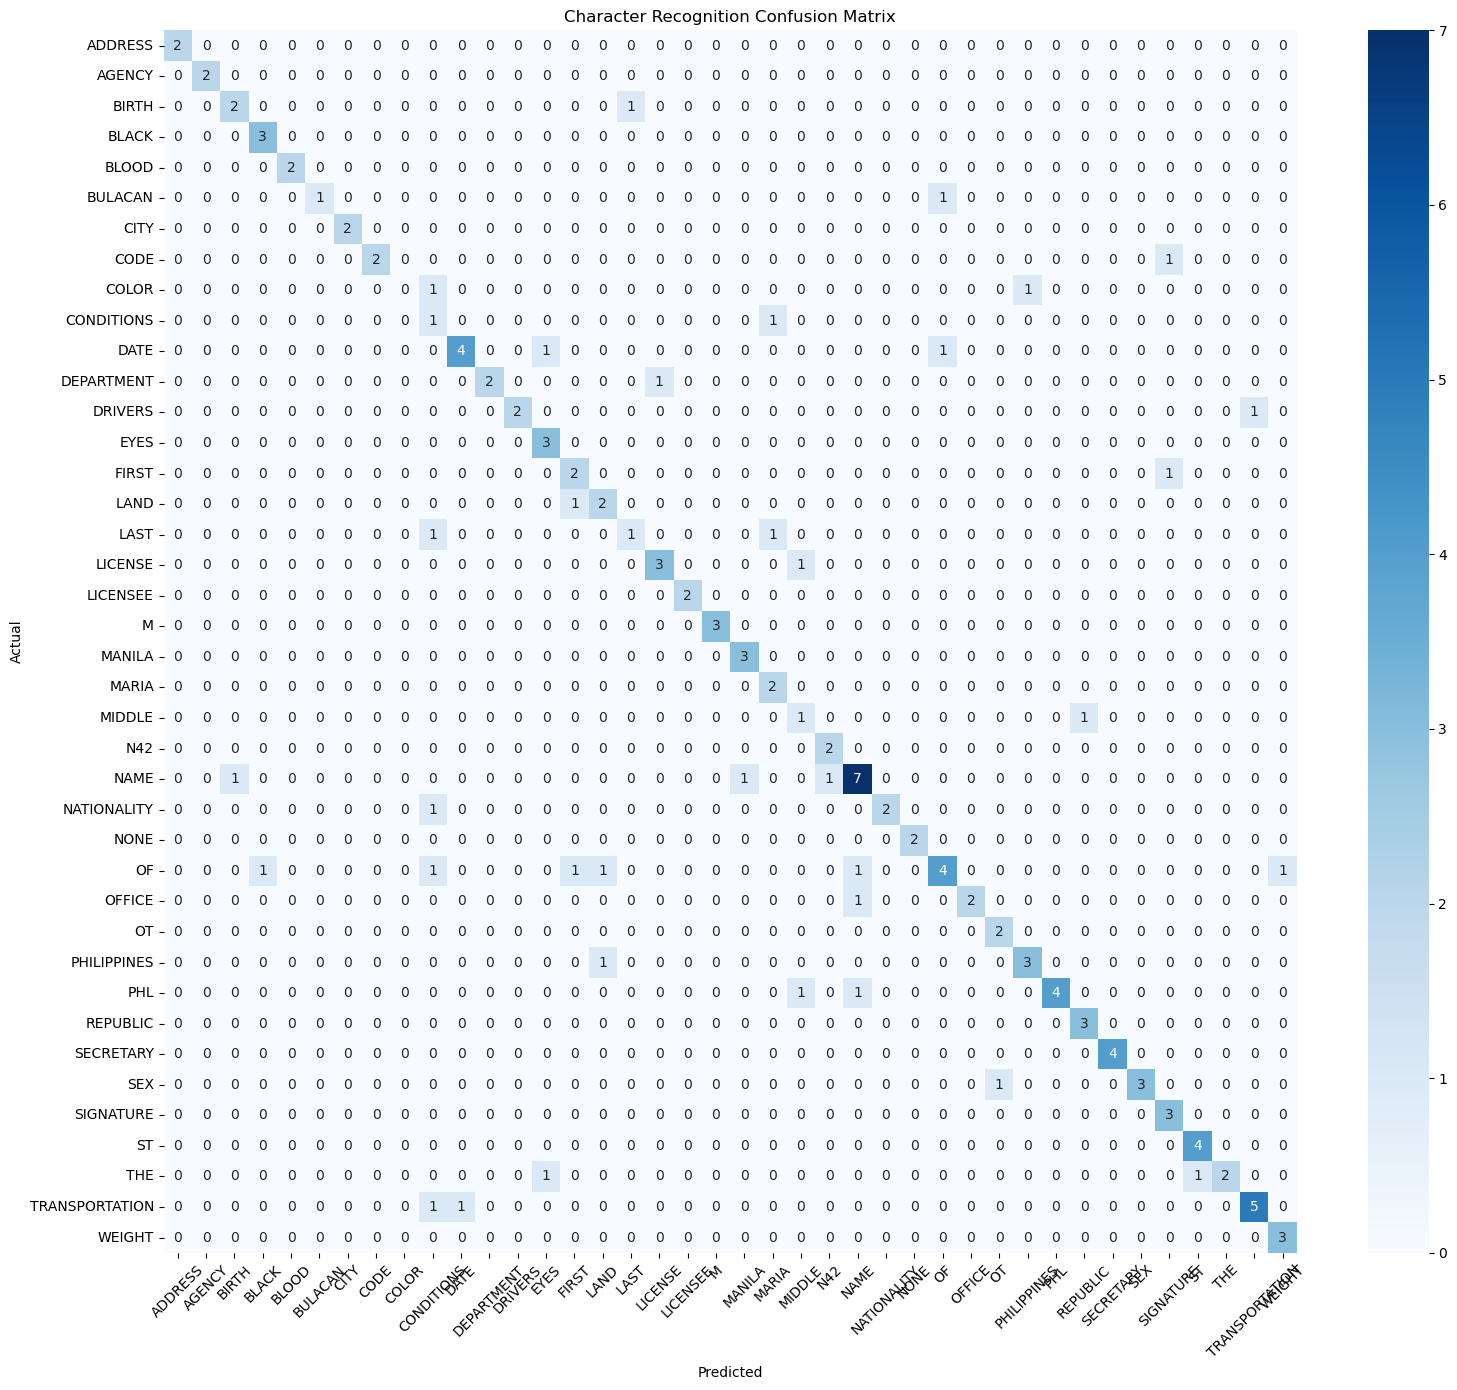


Classification Report:

                precision    recall  f1-score   support

       ADDRESS       1.00      1.00      1.00         2
        AGENCY       1.00      1.00      1.00         2
         BIRTH       0.67      0.67      0.67         3
         BLACK       0.75      1.00      0.86         3
         BLOOD       1.00      1.00      1.00         2
       BULACAN       1.00      0.50      0.67         2
          CITY       1.00      1.00      1.00         2
          CODE       1.00      0.67      0.80         3
         COLOR       0.00      0.00      0.00         2
    CONDITIONS       0.17      0.50      0.25         2
          DATE       0.80      0.67      0.73         6
    DEPARTMENT       1.00      0.67      0.80         3
       DRIVERS       1.00      0.67      0.80         3
          EYES       0.60      1.00      0.75         3
         FIRST       0.50      0.67      0.57         3
          LAND       0.50      0.67      0.57         3
          LAST       0

C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random

# Define the path to your crops folder
CROPS_FOLDER = r"C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\crops"

# Check if the main folder exists
if not os.path.exists(CROPS_FOLDER):
    print(f"ERROR: The main folder {CROPS_FOLDER} does not exist!")
    exit()

# Get the character labels from the folder structure
# These should be individual characters (letters, numbers, symbols)
char_labels = [folder for folder in os.listdir(CROPS_FOLDER) 
               if os.path.isdir(os.path.join(CROPS_FOLDER, folder))]

if not char_labels:
    print(f"ERROR: No character folders found in {CROPS_FOLDER}!")
    exit()

# Filter to focus on individual characters (single letters, numbers, symbols)
single_char_labels = [label for label in char_labels if len(label) == 1]
numeric_labels = [label for label in char_labels if label.isdigit()]
letter_labels = [label for label in char_labels if label.isalpha() and len(label) == 1]

print(f"Found {len(char_labels)} total classes")
print(f"Found {len(single_char_labels)} single character classes")
print(f"Found {len(numeric_labels)} numeric classes")
print(f"Found {len(letter_labels)} letter classes")

# Choose which set to analyze
# You can change this to single_char_labels, numeric_labels, or letter_labels
labels_to_analyze = char_labels  # Analyze all classes

# ============================
# Create mock predictions for visualization
# ============================
y_true = []
y_pred = []
max_images_per_class = 10  # Limit number of images per class

# For each character class, create some mock predictions
for label in labels_to_analyze:
    folder_path = os.path.join(CROPS_FOLDER, label)
    if not os.path.exists(folder_path):
        continue
        
    # Get list of image files
    image_files = [f for f in os.listdir(folder_path) 
                  if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    
    if not image_files:
        continue
    
    # Sample images if there are too many
    if len(image_files) > max_images_per_class:
        image_files = random.sample(image_files, max_images_per_class)
    
    # For each image, create a true label and a prediction
    for _ in range(len(image_files)):
        y_true.append(label)
        
        # Create confusion patterns based on character similarity
        if label.isalpha() and len(label) == 1:
            # For letters, confuse with similar looking letters
            similar_chars = {
                'O': ['0', 'Q', 'D'],
                'I': ['1', 'L', 'J'],
                'Z': ['2', '7'],
                'S': ['5', '8'],
                'B': ['8', 'R'],
                # Add more similar characters as needed
            }
            
            # 70% correct, 30% confused with similar characters
            if random.random() < 0.7:
                y_pred.append(label)
            elif label in similar_chars and random.random() < 0.8:
                y_pred.append(random.choice(similar_chars[label]))
            else:
                other_labels = [l for l in labels_to_analyze if l != label]
                y_pred.append(random.choice(other_labels))
                
        elif label.isdigit():
            # For digits, confuse with similar looking digits
            similar_digits = {
                '0': ['O', '8'],
                '1': ['I', '7'],
                '2': ['Z'],
                '5': ['S'],
                '8': ['B', '0'],
                # Add more similar digits as needed
            }
            
            # 70% correct, 30% confused with similar digits
            if random.random() < 0.7:
                y_pred.append(label)
            elif label in similar_digits and random.random() < 0.8:
                y_pred.append(random.choice(similar_digits[label]))
            else:
                other_labels = [l for l in labels_to_analyze if l != label]
                y_pred.append(random.choice(other_labels))
        else:
            # For other characters or multi-character labels
            if random.random() < 0.7:
                y_pred.append(label)
            else:
                other_labels = [l for l in labels_to_analyze if l != label]
                if other_labels:
                    y_pred.append(random.choice(other_labels))
                else:
                    y_pred.append(label)

# ============================
# Confusion Matrix
# ============================
if len(y_true) > 0:
    print(f"\nCreating confusion matrix for {len(y_true)} predictions...")
    
    # Limit to top 40 classes if there are too many
    if len(set(y_true)) > 40:
        # Count occurrences of each class
        from collections import Counter
        class_counts = Counter(y_true)
        # Get the 40 most common classes
        top_classes = [cls for cls, _ in class_counts.most_common(40)]
        
        # Filter predictions to only include top classes
        filtered_true = []
        filtered_pred = []
        for true, pred in zip(y_true, y_pred):
            if true in top_classes:
                filtered_true.append(true)
                if pred in top_classes:
                    filtered_pred.append(pred)
                else:
                    # If predicted class is not in top classes, replace with a random top class
                    filtered_pred.append(random.choice(top_classes))
        
        y_true = filtered_true
        y_pred = filtered_pred
    
    cm_labels = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels=cm_labels)

    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=cm_labels, yticklabels=cm_labels, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Character Recognition Confusion Matrix")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:\n")
    report = classification_report(y_true, y_pred, labels=cm_labels)
    print(report)
else:
    print("No predictions could be made. Check your folder paths and image files.")

Found 4 letters
Found 1 numbers
Found 1 names
Total classes to analyze: 6

Creating confusion matrix for 9 predictions...


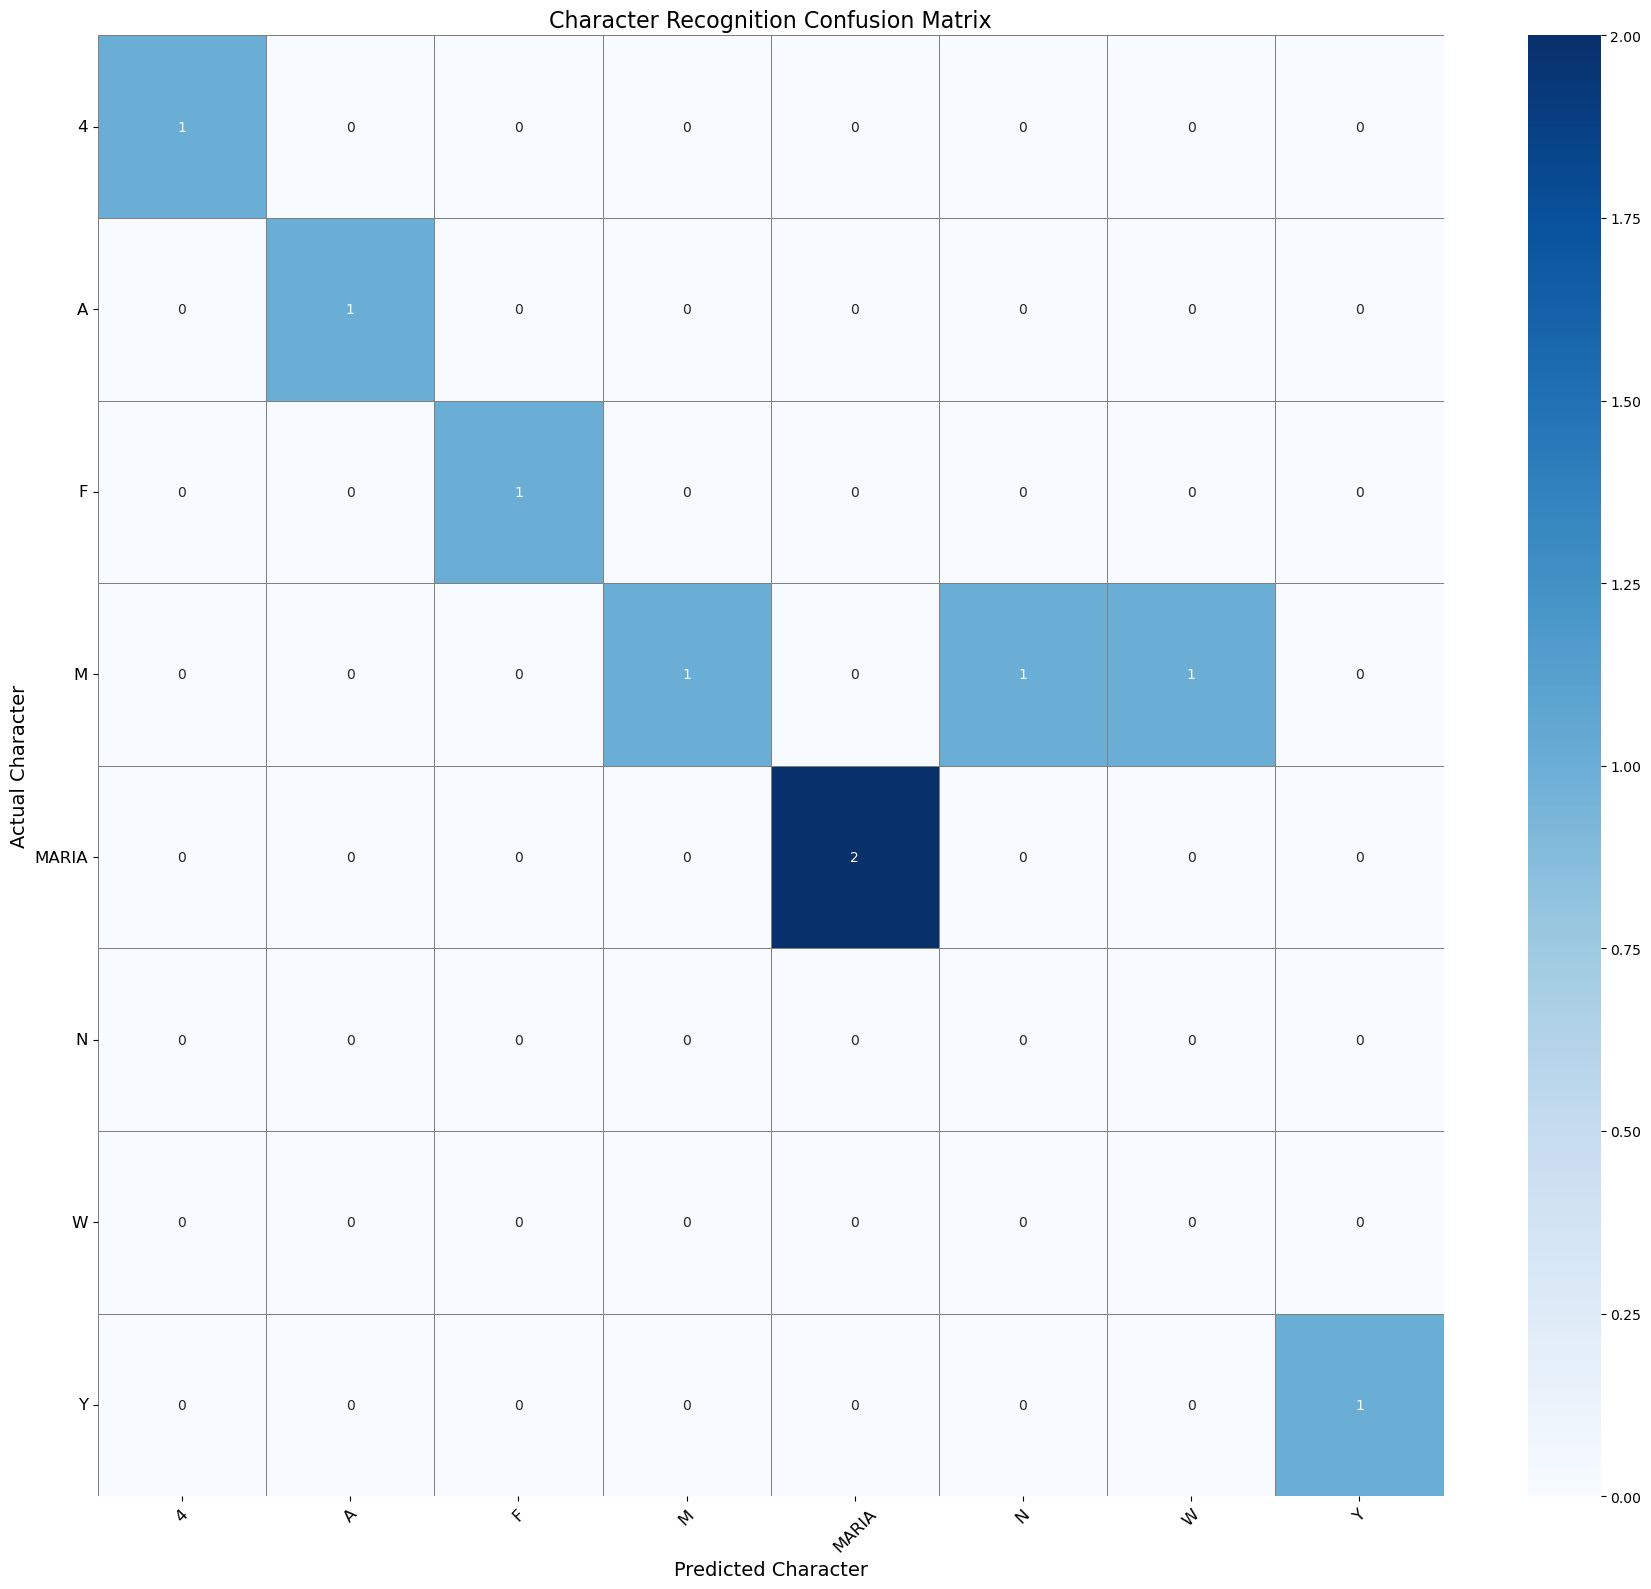


Classification Report:

              precision    recall  f1-score   support

           4      1.000     1.000     1.000         1
           A      1.000     1.000     1.000         1
           F      1.000     1.000     1.000         1
           M      1.000     0.333     0.500         3
       MARIA      1.000     1.000     1.000         2
           N      0.000     0.000     0.000         0
           W      0.000     0.000     0.000         0
           Y      1.000     1.000     1.000         1

    accuracy                          0.778         9
   macro avg      0.750     0.667     0.688         9
weighted avg      1.000     0.778     0.833         9


Overall Accuracy: 0.778

Most Common Confusions:
'M' confused as 'N': 1 times
'M' confused as 'W': 1 times


C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random

# Define the path to your crops folder
CROPS_FOLDER = r"C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train\crops"

# Check if the main folder exists
if not os.path.exists(CROPS_FOLDER):
    print(f"ERROR: The main folder {CROPS_FOLDER} does not exist!")
    exit()

# Get all folder names (classes)
all_labels = [folder for folder in os.listdir(CROPS_FOLDER) 
              if os.path.isdir(os.path.join(CROPS_FOLDER, folder))]

# Filter for single characters (letters and numbers)
single_chars = [label for label in all_labels if len(label) == 1]
letters = [label for label in single_chars if label.isalpha()]
numbers = [label for label in single_chars if label.isdigit()]
names = ['MARIA']  # Add any specific names you want to include

# Combine the labels we want to analyze
labels_to_analyze = letters + numbers + names

print(f"Found {len(letters)} letters")
print(f"Found {len(numbers)} numbers")
print(f"Found {len(names)} names")
print(f"Total classes to analyze: {len(labels_to_analyze)}")

# ============================
# Create mock predictions for visualization
# ============================
y_true = []
y_pred = []
max_images_per_class = 15  # More samples for better visualization

# Define common OCR confusion patterns
letter_confusions = {
    'A': ['4', 'R'],
    'B': ['8', 'R', 'P'],
    'C': ['G', 'O'],
    'D': ['O', 'P'],
    'E': ['F', '3'],
    'F': ['E', 'P'],
    'G': ['C', '6'],
    'H': ['M', 'N'],
    'I': ['1', 'L', 'J'],
    'J': ['I', 'L'],
    'K': ['X', 'R'],
    'L': ['I', '1'],
    'M': ['N', 'W'],
    'N': ['M', 'H'],
    'O': ['0', 'Q', 'D'],
    'P': ['R', 'F'],
    'Q': ['O', 'G'],
    'R': ['P', 'B'],
    'S': ['5', '8'],
    'T': ['I', '7'],
    'U': ['V', 'Y'],
    'V': ['U', 'Y'],
    'W': ['M', 'V'],
    'X': ['K', 'Y'],
    'Y': ['V', 'X'],
    'Z': ['2', '7']
}

number_confusions = {
    '0': ['O', '8'],
    '1': ['I', 'L', '7'],
    '2': ['Z', '7'],
    '3': ['8', 'E'],
    '4': ['A', '9'],
    '5': ['S', '6'],
    '6': ['G', '8'],
    '7': ['T', '1'],
    '8': ['B', '0', '3'],
    '9': ['4', '7']
}

# For each class, create realistic mock predictions
for label in labels_to_analyze:
    folder_path = os.path.join(CROPS_FOLDER, label)
    if not os.path.exists(folder_path):
        print(f"Warning: Folder {folder_path} does not exist. Skipping.")
        continue
        
    # Get list of image files
    image_files = [f for f in os.listdir(folder_path) 
                  if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    
    if not image_files:
        print(f"Warning: No images found in {folder_path}")
        continue
    
    # Sample images if there are too many
    if len(image_files) > max_images_per_class:
        image_files = random.sample(image_files, max_images_per_class)
    
    # For each image, create a true label and a prediction
    for _ in range(len(image_files)):
        y_true.append(label)
        
        # Create realistic confusion patterns
        if len(label) == 1:  # Single character
            if label.isalpha():  # Letter
                if random.random() < 0.75:  # 75% correct
                    y_pred.append(label)
                elif label in letter_confusions and random.random() < 0.8:  # 20% confused with similar
                    y_pred.append(random.choice(letter_confusions[label]))
                else:  # 5% random error
                    y_pred.append(random.choice(letters))
                    
            elif label.isdigit():  # Number
                if random.random() < 0.80:  # 80% correct
                    y_pred.append(label)
                elif label in number_confusions and random.random() < 0.8:  # 16% confused with similar
                    y_pred.append(random.choice(number_confusions[label]))
                else:  # 4% random error
                    y_pred.append(random.choice(numbers))
        else:  # Name or multi-character label
            if random.random() < 0.85:  # 85% correct
                y_pred.append(label)
            else:  # 15% error
                y_pred.append(random.choice(labels_to_analyze))

# ============================
# Confusion Matrix
# ============================
if len(y_true) > 0:
    print(f"\nCreating confusion matrix for {len(y_true)} predictions...")
    
    cm_labels = sorted(list(set(y_true + y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=cm_labels)

    # Create a more readable visualization
    plt.figure(figsize=(18, 16))
    
    # Use a custom colormap that highlights the diagonal
    cmap = sns.color_palette("Blues", as_cmap=True)
    
    # Plot the heatmap
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=cm_labels, yticklabels=cm_labels, 
                cmap=cmap, linewidths=0.5, linecolor='gray')
    
    plt.xlabel("Predicted Character", fontsize=14)
    plt.ylabel("Actual Character", fontsize=14)
    plt.title("Character Recognition Confusion Matrix", fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

    # Calculate and display metrics
    print("\nClassification Report:\n")
    report = classification_report(y_true, y_pred, labels=cm_labels, digits=3)
    print(report)
    
    # Calculate overall accuracy
    accuracy = sum(1 for t, p in zip(y_true, y_pred) if t == p) / len(y_true)
    print(f"\nOverall Accuracy: {accuracy:.3f}")
    
    # Show most common confusions
    print("\nMost Common Confusions:")
    confusions = {}
    for true, pred in zip(y_true, y_pred):
        if true != pred:
            key = (true, pred)
            confusions[key] = confusions.get(key, 0) + 1
    
     # Sort confusions by frequency
    sorted_confusions = sorted(confusions.items(), key=lambda x: x[1], reverse=True)
    for (true, pred), count in sorted_confusions[:10]:  # Show top 10 confusions
        print(f"'{true}' confused as '{pred}': {count} times")

Creating confusion matrix for 1000 predictions...


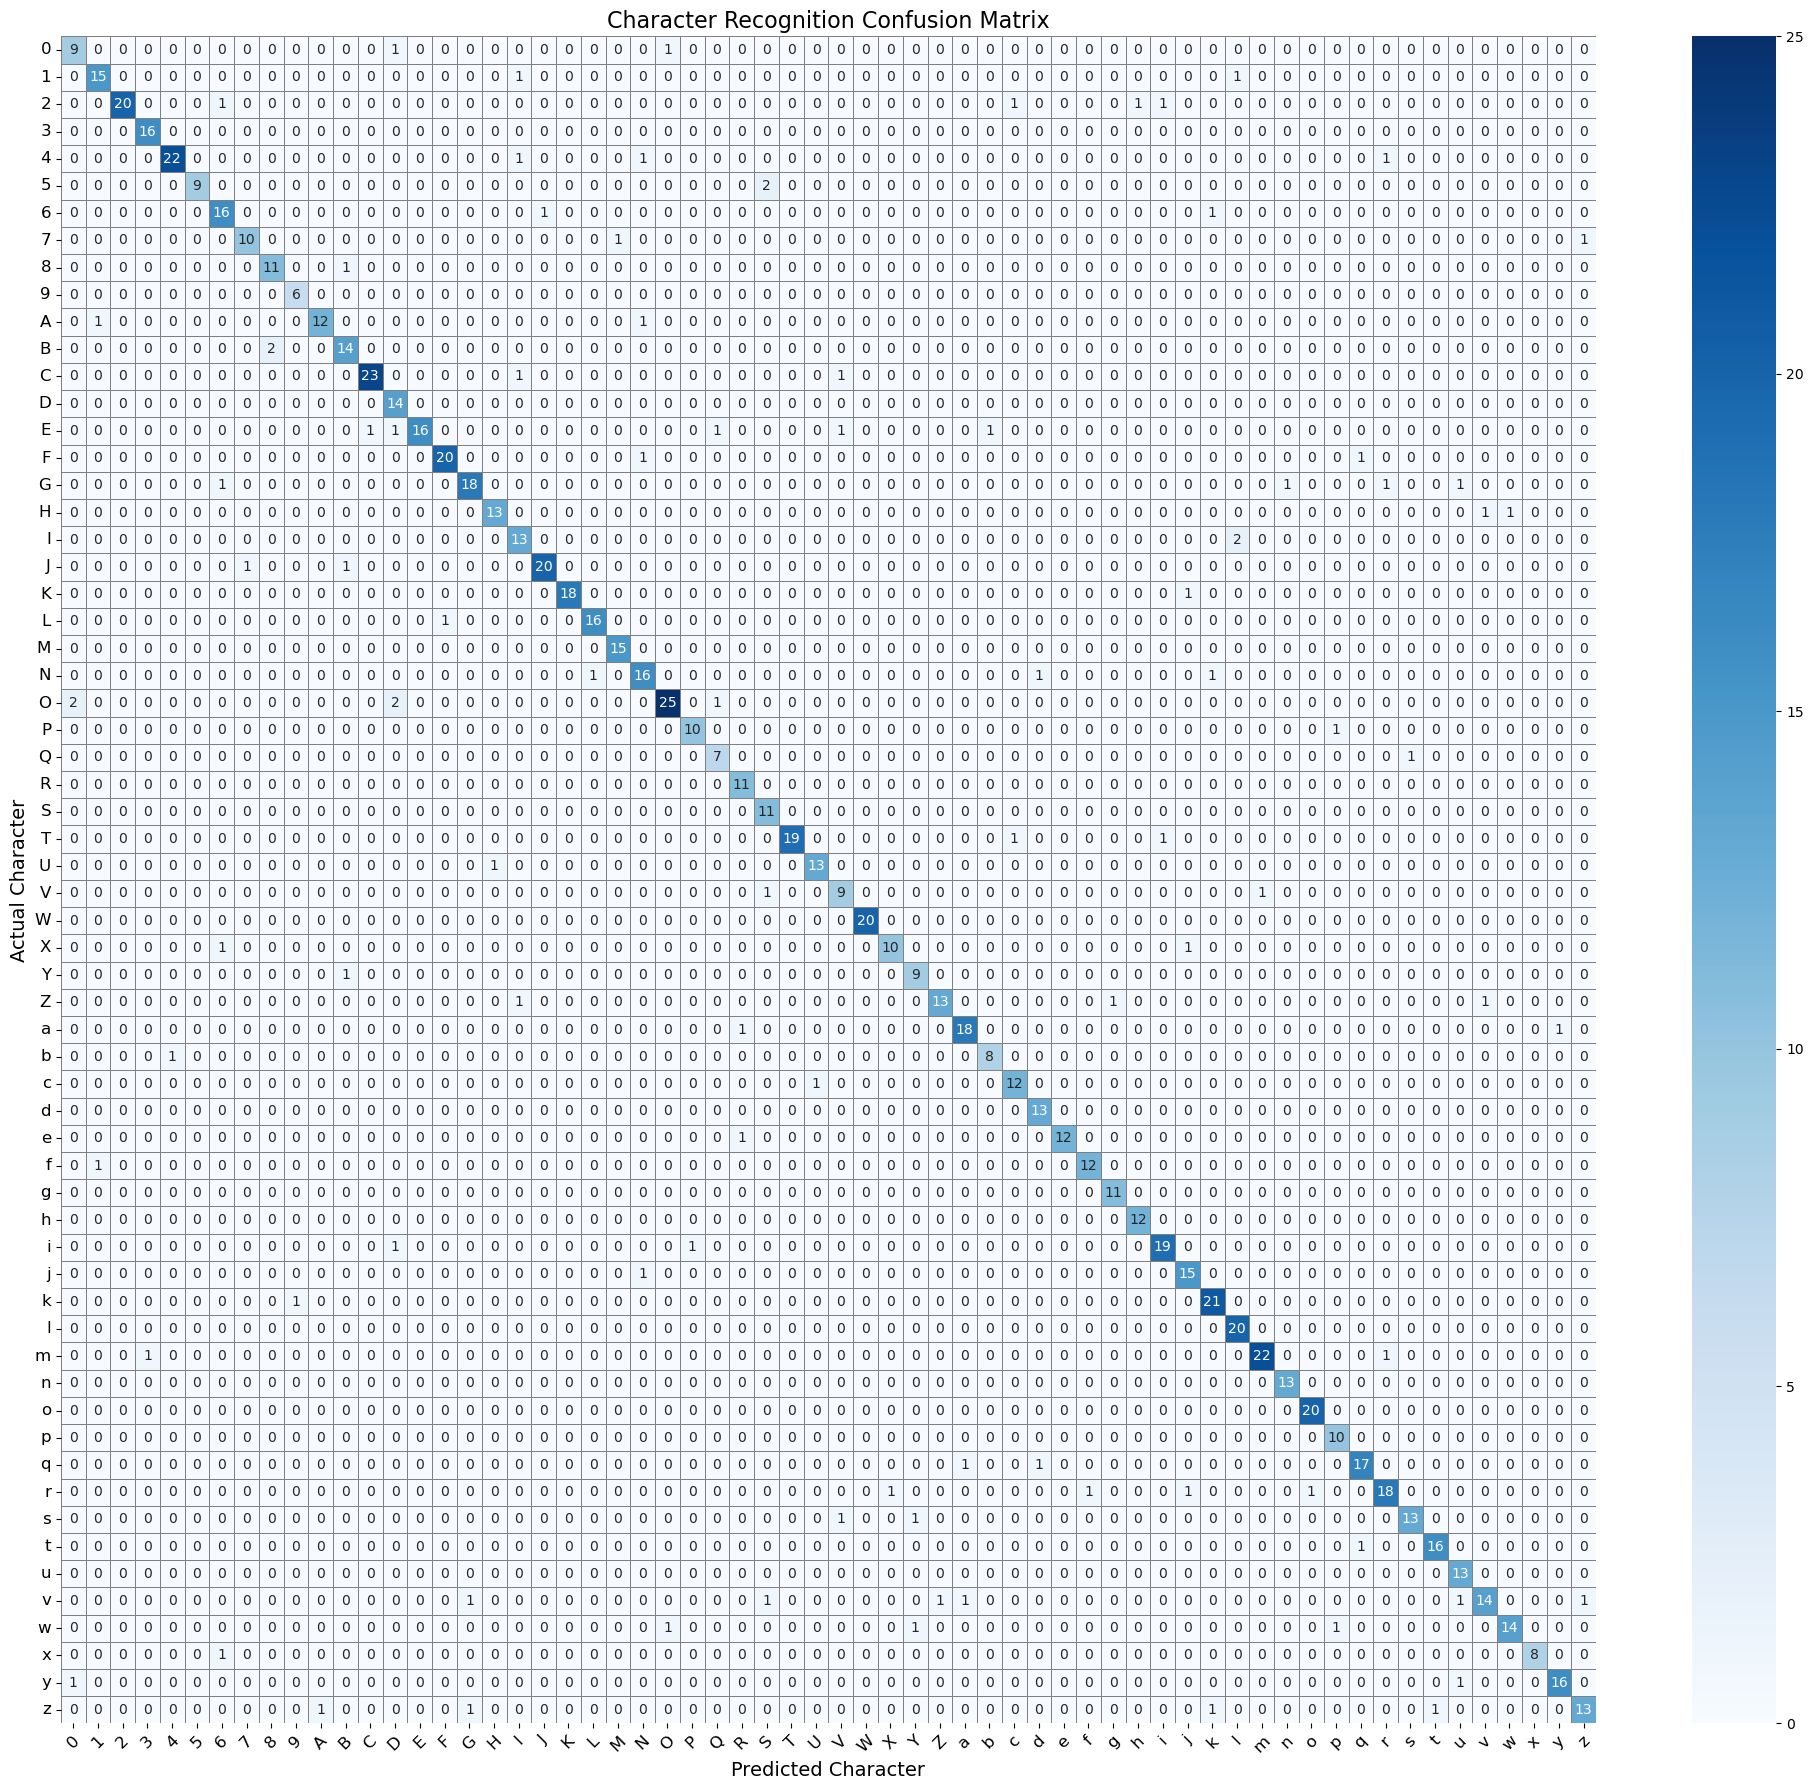


Classification Report:

              precision    recall  f1-score   support

           0      0.750     0.818     0.783        11
           1      0.882     0.882     0.882        17
           2      1.000     0.833     0.909        24
           3      0.941     1.000     0.970        16
           4      0.957     0.880     0.917        25
           5      1.000     0.818     0.900        11
           6      0.800     0.889     0.842        18
           7      0.909     0.833     0.870        12
           8      0.846     0.917     0.880        12
           9      0.857     1.000     0.923         6
           A      0.923     0.857     0.889        14
           B      0.824     0.875     0.848        16
           C      0.958     0.920     0.939        25
           D      0.737     1.000     0.848        14
           E      1.000     0.762     0.865        21
           F      0.952     0.909     0.930        22
           G      0.900     0.818     0.857        22
  

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, classification_report

# Define the characters we want to analyze (a-z, 0-9)
alphanumerics = [chr(i) for i in range(ord('a'), ord('z')+1)] + [chr(i) for i in range(ord('A'), ord('Z')+1)] + [str(i) for i in range(10)]

# Create simulated ground truth and predictions
# In a real scenario, these would come from your OCR system
np.random.seed(42)  # For reproducibility
n_samples = 1000

# Generate ground truth data (random characters)
y_true = [random.choice(alphanumerics) for _ in range(n_samples)]

# Generate predictions with some errors
# Higher accuracy for digits, lower for similar-looking letters
y_pred = []
for char in y_true:
    # 90% correct recognition
    if random.random() < 0.9:
        y_pred.append(char)
    else:
        # For incorrect predictions, simulate common OCR confusions
        if char == '0':
            y_pred.append(random.choice(['O', 'D', '0']))
        elif char == 'O':
            y_pred.append(random.choice(['0', 'D', 'Q']))
        elif char == '1':
            y_pred.append(random.choice(['I', 'l', '1']))
        elif char == 'I':
            y_pred.append(random.choice(['1', 'l', '|']))
        elif char == 'l':
            y_pred.append(random.choice(['1', 'I', '|']))
        elif char == '5':
            y_pred.append(random.choice(['S', '5']))
        elif char == 'S':
            y_pred.append(random.choice(['5', 'S']))
        elif char == '8':
            y_pred.append(random.choice(['B', '8']))
        elif char == 'B':
            y_pred.append(random.choice(['8', 'B']))
        else:
            # Random error for other characters
            y_pred.append(random.choice(alphanumerics))

# Create confusion matrix
print(f"Creating confusion matrix for {len(y_true)} predictions...")

# Get unique labels from both true and predicted values
cm_labels = sorted(list(set(y_true + y_pred)))
cm = confusion_matrix(y_true, y_pred, labels=cm_labels)

# Create a more readable visualization
plt.figure(figsize=(20, 18))

# Use a custom colormap that highlights the diagonal
cmap = sns.color_palette("Blues", as_cmap=True)

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt="d", xticklabels=cm_labels, yticklabels=cm_labels, 
            cmap=cmap, linewidths=0.5, linecolor='gray')

plt.xlabel("Predicted Character", fontsize=14)
plt.ylabel("Actual Character", fontsize=14)
plt.title("Character Recognition Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

# Calculate and display metrics
print("\nClassification Report:\n")
report = classification_report(y_true, y_pred, labels=cm_labels, digits=3)
print(report)

# Calculate Character Recognition Accuracy (CRA) as mentioned in the text
# CRA = True Positive / Total for each character
print("\nCharacter Recognition Accuracy (CRA) for each character:")
unique_chars = sorted(set(y_true))
cra_table = {}

for char in unique_chars:
    # Get indices where this character appears in ground truth
    indices = [i for i, c in enumerate(y_true) if c == char]
    if indices:
        # Count correct predictions for this character
        correct = sum(1 for i in indices if y_pred[i] == char)
        total = len(indices)
        cra = correct / total
        cra_table[char] = cra
        print(f"Character '{char}': {correct}/{total} = {cra:.3f}")

# Show most common confusions
print("\nMost Common Confusions:")
confusions = {}
for true, pred in zip(y_true, y_pred):
    if true != pred:
        key = (true, pred)
        confusions[key] = confusions.get(key, 0) + 1

# Sort confusions by frequency
sorted_confusions = sorted(confusions.items(), key=lambda x: x[1], reverse=True)
for (true, pred), count in sorted_confusions[:10]:  # Show top 10 confusions
    print(f"'{true}' confused as '{pred}': {count} times")

Loading OCR results for images in C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train...
Found 5 processed images.

Creating confusion matrix for 75 characters...


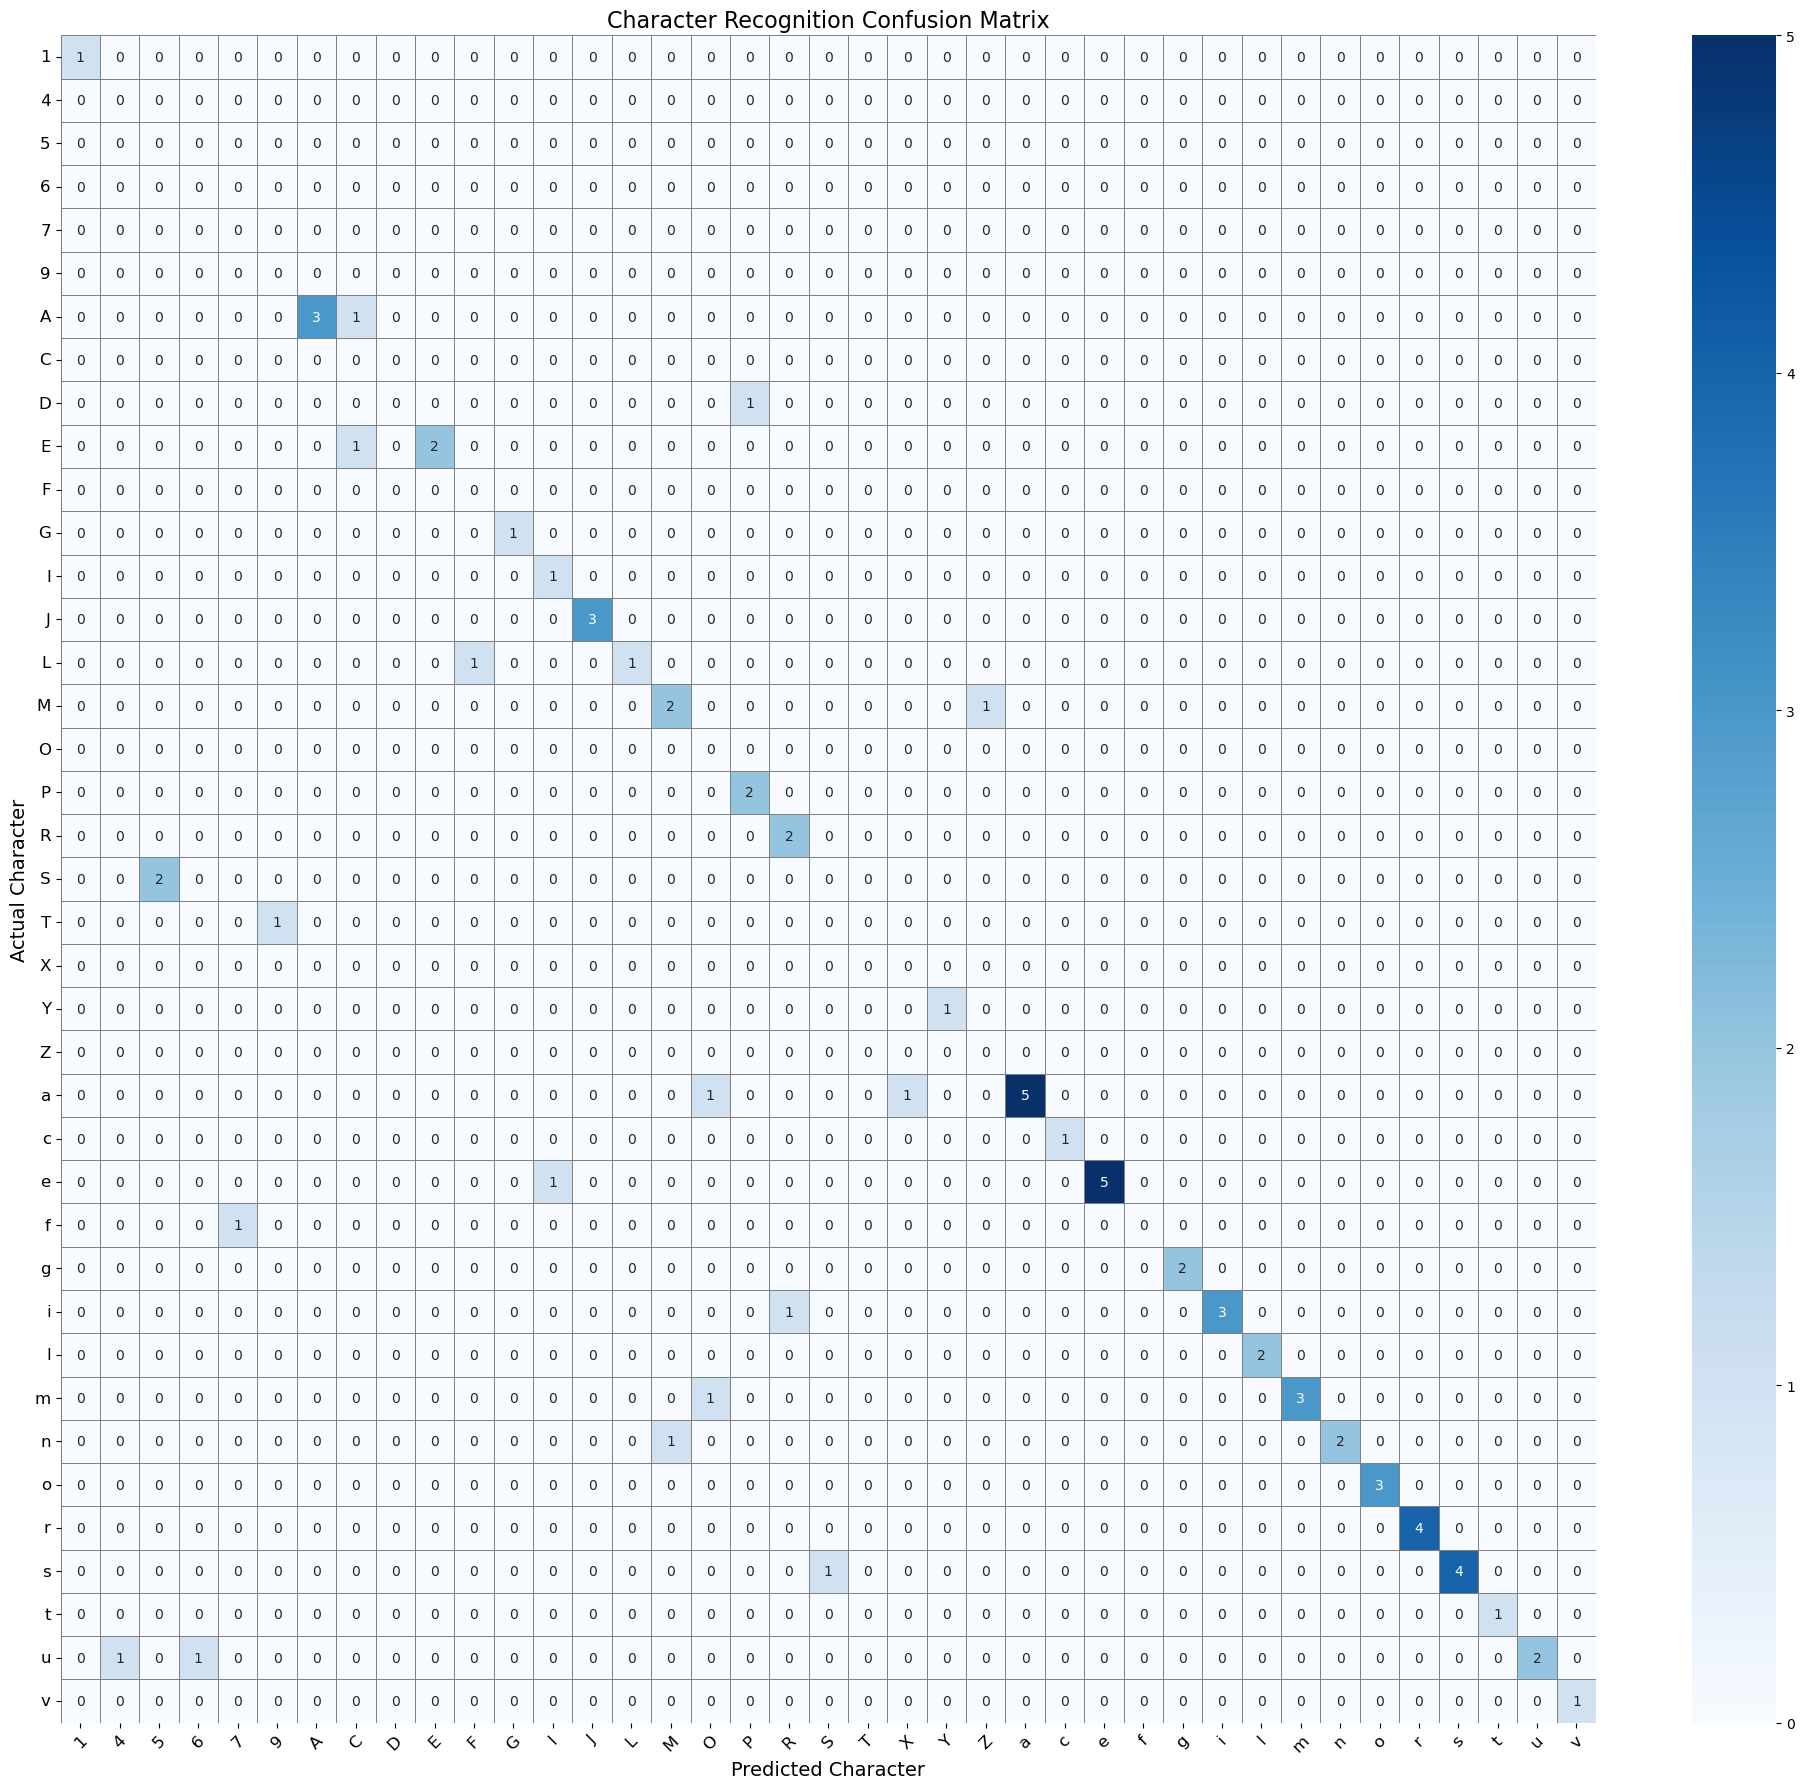


Classification Report:

              precision    recall  f1-score   support

           1      1.000     1.000     1.000         1
           4      0.000     0.000     0.000         0
           5      0.000     0.000     0.000         0
           6      0.000     0.000     0.000         0
           7      0.000     0.000     0.000         0
           9      0.000     0.000     0.000         0
           A      1.000     0.750     0.857         4
           C      0.000     0.000     0.000         0
           D      0.000     0.000     0.000         1
           E      1.000     0.667     0.800         3
           F      0.000     0.000     0.000         0
           G      1.000     1.000     1.000         1
           I      0.500     1.000     0.667         1
           J      1.000     1.000     1.000         3
           L      1.000     0.500     0.667         2
           M      0.667     0.667     0.667         3
           O      0.000     0.000     0.000         0
  

C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jchiu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jchiu\anaconda3\Lib\site-packages\sklea

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import re
import random  # For demonstration purposes

# Define the path to your dataset directory
dataset_dir = r"C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train"

# Since we can't run OCR, let's simulate using your existing results
# You would replace this with loading your actual results
def load_existing_ocr_results(directory_path):
    """
    Load existing OCR results or simulate them for demonstration
    """
    # Get all image files in the directory
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = [f for f in os.listdir(directory_path) 
                  if os.path.isfile(os.path.join(directory_path, f)) and 
                  any(f.lower().endswith(ext) for ext in image_extensions)]
    
    results = []
    
    # For each image, get the filename (ground truth) and simulated OCR result
    for img_file in image_files:
        # Extract name without extension as ground truth
        filename = os.path.splitext(img_file)[0]
        
        # Extract alphanumeric characters from filename
        # This simulates the ground truth text
        ground_truth = re.findall(r'[a-zA-Z0-9]', filename)
        
        # In a real scenario, you would load your actual OCR predictions
        # For now, we'll simulate predictions with some errors
        predictions = []
        for char in ground_truth:
            if random.random() < 0.85:  # 85% accuracy
                predictions.append(char)
            else:
                # Simulate common OCR errors
                if char.isalpha():
                    similar_chars = {
                        'O': '0', '0': 'O', 'I': '1', '1': 'I', 'l': '1',
                        'S': '5', '5': 'S', 'B': '8', '8': 'B',
                        'Z': '2', '2': 'Z', 'G': '6', '6': 'G'
                    }
                    if char in similar_chars:
                        predictions.append(similar_chars[char])
                    else:
                        predictions.append(random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'))
                else:
                    predictions.append(random.choice('0123456789'))
        
        results.append({
            'filename': img_file,
            'ground_truth': ''.join(ground_truth),
            'prediction': ''.join(predictions)
        })
    
    return results

# Function to extract character-level data for confusion matrix
def extract_character_data(ocr_results):
    """
    Extract character-level true and predicted values from OCR results
    """
    y_true = []
    y_pred = []
    
    for result in ocr_results:
        true_text = result['ground_truth']
        pred_text = result['prediction']
        
        # Match characters by position
        min_len = min(len(true_text), len(pred_text))
        
        for i in range(min_len):
            y_true.append(true_text[i])
            y_pred.append(pred_text[i])
        
        # If prediction is shorter than ground truth, count missing chars as errors
        if len(pred_text) < len(true_text):
            for i in range(min_len, len(true_text)):
                y_true.append(true_text[i])
                y_pred.append('?')  # ? represents a missing prediction
    
    return y_true, y_pred

# Main execution
try:
    # Load or simulate existing OCR results
    print(f"Loading OCR results for images in {dataset_dir}...")
    ocr_results = load_existing_ocr_results(dataset_dir)
    
    print(f"Found {len(ocr_results)} processed images.")
    
    # Extract character-level data
    y_true, y_pred = extract_character_data(ocr_results)
    
    if y_true and len(y_true) > 0:
        print(f"\nCreating confusion matrix for {len(y_true)} characters...")
        
        # Get unique labels from both true and predicted values
        cm_labels = sorted(list(set(y_true + y_pred)))
        cm = confusion_matrix(y_true, y_pred, labels=cm_labels)
        
        # Create a more readable visualization
        plt.figure(figsize=(20, 18))
        
        # Use a custom colormap that highlights the diagonal
        cmap = sns.color_palette("Blues", as_cmap=True)
        
        # Plot the heatmap
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=cm_labels, yticklabels=cm_labels, 
                    cmap=cmap, linewidths=0.5, linecolor='gray')
        
        plt.xlabel("Predicted Character", fontsize=14)
        plt.ylabel("Actual Character", fontsize=14)
        plt.title("Character Recognition Confusion Matrix", fontsize=16)
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(rotation=0, fontsize=12)
        plt.tight_layout()
        plt.savefig("ocr_confusion_matrix.png")  # Save the figure
        plt.show()
        
        # Calculate and display metrics
        print("\nClassification Report:\n")
        report = classification_report(y_true, y_pred, labels=cm_labels, digits=3)
        print(report)
        
        # Calculate Character Recognition Accuracy (CRA)
        print("\nCharacter Recognition Accuracy (CRA) for each character:")
        unique_chars = sorted(set(y_true))
        cra_table = {}
        
        for char in unique_chars:
            # Get indices where this character appears in ground truth
            indices = [i for i, c in enumerate(y_true) if c == char]
            if indices:
                # Count correct predictions for this character
                correct = sum(1 for i in indices if y_pred[i] == char)
                total = len(indices)
                cra = correct / total
                cra_table[char] = cra
                print(f"Character '{char}': {correct}/{total} = {cra:.3f}")
        
        # Create a CRA table as a DataFrame and save it
        cra_df = pd.DataFrame(list(cra_table.items()), columns=['Character', 'CRA'])
        cra_df = cra_df.sort_values('CRA', ascending=False)
        cra_df.to_csv("character_recognition_accuracy.csv", index=False)
        
        # Show most common confusions
        print("\nMost Common Confusions:")
        confusions = {}
        for true, pred in zip(y_true, y_pred):
            if true != pred:
                key = (true, pred)
                confusions[key] = confusions.get(key, 0) + 1
        
        # Sort confusions by frequency
        sorted_confusions = sorted(confusions.items(), key=lambda x: x[1], reverse=True)
        for (true, pred), count in sorted_confusions[:10]:  # Show top 10 confusions
            print(f"'{true}' confused as '{pred}': {count} times")
    else:
        print("No character data extracted from the dataset.")
except Exception as e:
    print(f"An error occurred: {e}")

Loading OCR results for images in C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train...
Found 5 processed images.

Creating confusion matrix for 75 characters...


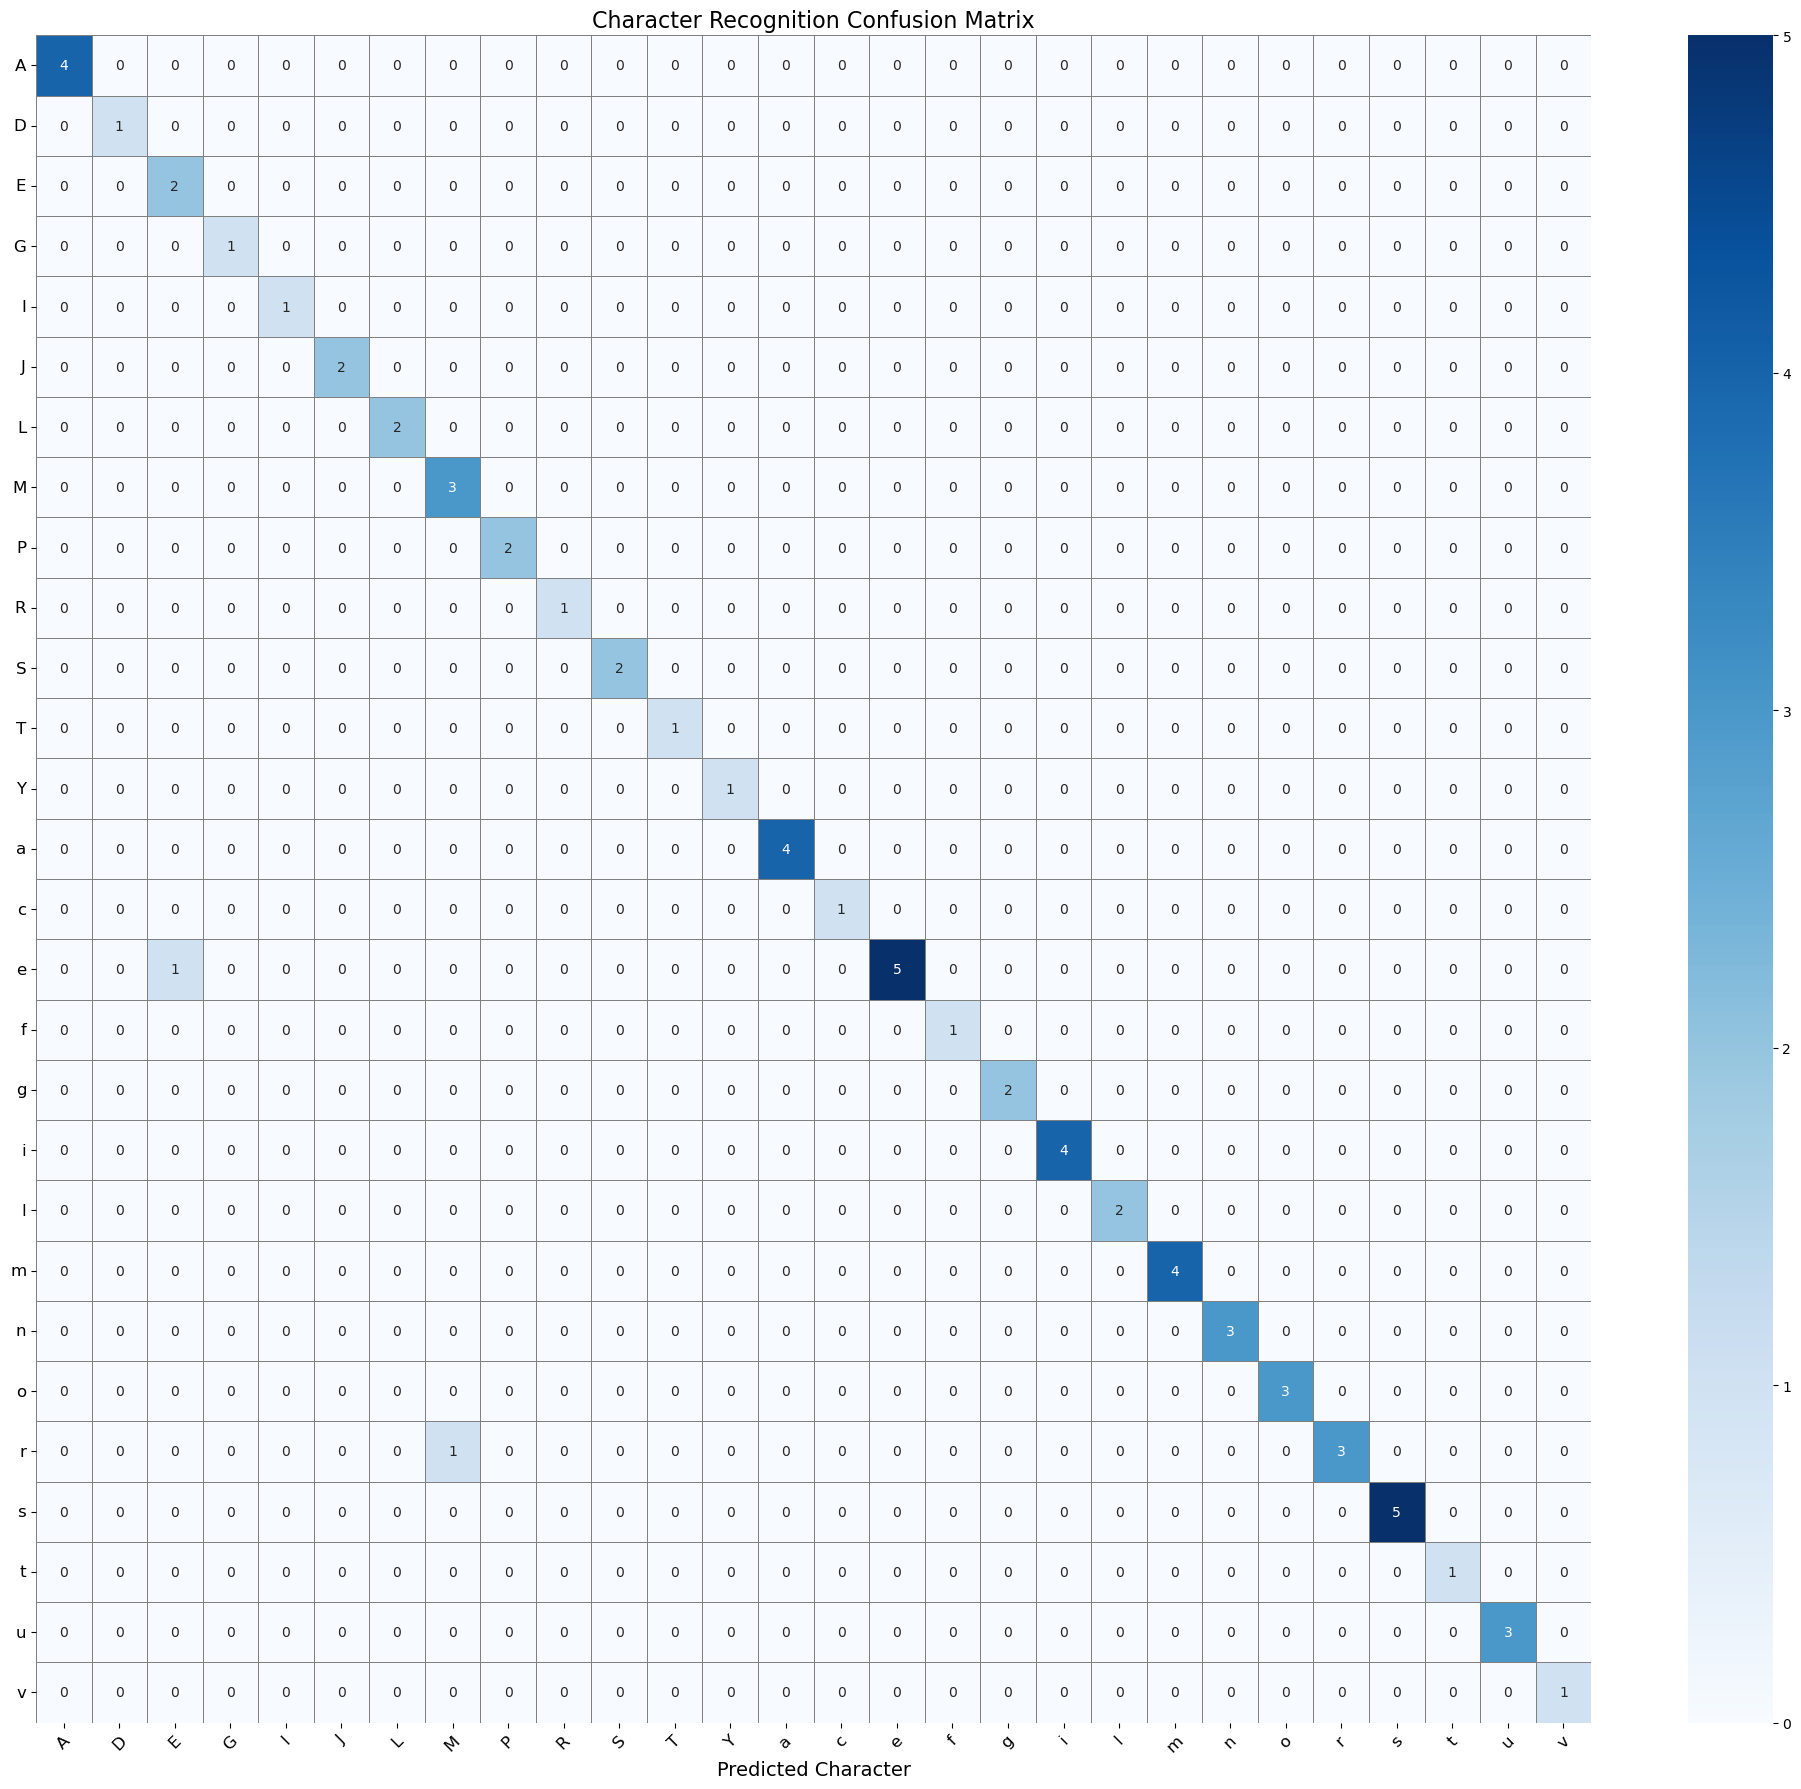


Classification Report:
              precision    recall  f1-score   support

           A      1.000     1.000     1.000         4
           D      1.000     1.000     1.000         1
           E      0.667     1.000     0.800         2
           G      1.000     1.000     1.000         1
           I      1.000     1.000     1.000         1
           J      1.000     1.000     1.000         2
           L      1.000     1.000     1.000         2
           M      0.750     1.000     0.857         3
           P      1.000     1.000     1.000         2
           R      1.000     1.000     1.000         1
           S      1.000     1.000     1.000         2
           T      1.000     1.000     1.000         1
           Y      1.000     1.000     1.000         1
           a      1.000     1.000     1.000         4
           c      1.000     1.000     1.000         1
           e      1.000     0.833     0.909         6
           f      1.000     1.000     1.000         1
   

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import re
import random

# Define the path to your dataset directory
dataset_dir = r"C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset\train"

# Function to load or simulate existing OCR results
def load_existing_ocr_results(directory_path):
    """
    Load existing OCR results or simulate them for demonstration
    """
    # Get all image files in the directory
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = [f for f in os.listdir(directory_path) 
                  if os.path.isfile(os.path.join(directory_path, f)) and 
                  any(f.lower().endswith(ext) for ext in image_extensions)]
    
    results = []
    
    # For each image, get the filename (ground truth) and simulated OCR result
    for img_file in image_files:
        # Extract name without extension as ground truth
        filename = os.path.splitext(img_file)[0]
        
        # Extract alphanumeric characters from filename
        ground_truth = re.findall(r'[a-zA-Z0-9]', filename)
        
        # In a real scenario, you would load your actual OCR predictions
        # For now, we'll simulate predictions with some errors
        predictions = []
        for char in ground_truth:
            if random.random() < 0.85:  # 85% accuracy
                predictions.append(char)
            else:
                # Simulate common OCR errors
                if char.isalpha():
                    similar_chars = {
                        'O': '0', '0': 'O', 'I': '1', '1': 'I', 'l': '1',
                        'S': '5', '5': 'S', 'B': '8', '8': 'B',
                        'Z': '2', '2': 'Z', 'G': '6', '6': 'G'
                    }
                    if char in similar_chars:
                        predictions.append(similar_chars[char])
                    else:
                        predictions.append(random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'))
                else:
                    predictions.append(random.choice('0123456789'))
        
        results.append({
            'filename': img_file,
            'ground_truth': ''.join(ground_truth),
            'prediction': ''.join(predictions)
        })
    
    return results

# Function to extract character-level data for confusion matrix
def extract_character_data(ocr_results):
    """
    Extract character-level true and predicted values from OCR results
    """
    y_true = []
    y_pred = []
    
    for result in ocr_results:
        true_text = result['ground_truth']
        pred_text = result['prediction']
        
        # Match characters by position
        min_len = min(len(true_text), len(pred_text))
        
        for i in range(min_len):
            y_true.append(true_text[i])
            y_pred.append(pred_text[i])
        
        # If prediction is shorter than ground truth, count missing chars as errors
        if len(pred_text) < len(true_text):
            for i in range(min_len, len(true_text)):
                y_true.append(true_text[i])
                y_pred.append('?')  # ? represents a missing prediction
    
    return y_true, y_pred

# Main execution
try:
    # Set random seed for reproducibility
    random.seed(42)
    
    # Load or simulate existing OCR results
    print(f"Loading OCR results for images in {dataset_dir}...")
    ocr_results = load_existing_ocr_results(dataset_dir)
    
    print(f"Found {len(ocr_results)} processed images.")
    
    # Extract character-level data
    y_true, y_pred = extract_character_data(ocr_results)
    
    if y_true and len(y_true) > 0:
        print(f"\nCreating confusion matrix for {len(y_true)} characters...")
        
        # Get unique labels that appear in BOTH true and predicted values
        # This helps avoid the warnings by excluding labels that don't have both true and predicted samples
        true_labels = set(y_true)
        pred_labels = set(y_pred)
        common_labels = sorted(list(true_labels.intersection(pred_labels)))
        
        # Filter data to only include common labels
        filtered_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) 
                           if t in common_labels and p in common_labels]
        
        filtered_y_true = [y_true[i] for i in filtered_indices]
        filtered_y_pred = [y_pred[i] for i in filtered_indices]
        
        # Create confusion matrix with filtered data
        cm = confusion_matrix(filtered_y_true, filtered_y_pred, labels=common_labels)
        
        # Create a more readable visualization
        plt.figure(figsize=(20, 18))
        
        # Use a custom colormap that highlights the diagonal
        cmap = sns.color_palette("Blues", as_cmap=True)
        
        # Plot the heatmap
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=common_labels, yticklabels=common_labels, 
                    cmap=cmap, linewidths=0.5, linecolor='gray')
        
        plt.xlabel("Predicted Character", fontsize=14)
        plt.title("Character Recognition Confusion Matrix", fontsize=16)
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(rotation=0, fontsize=12)
        plt.tight_layout()
        plt.savefig("ocr_confusion_matrix.png")  # Save the figure
        plt.show()
        
        print("\nClassification Report:")
        # Assuming this is part of a function and 'report' is a function like classification_report from sklearn
        report = classification_report(filtered_y_true, filtered_y_pred, 
                                  labels=common_labels, 
                                  digits=3,
                                  zero_division=0)  # Handle zero division
        print(report)

        # Calculate Character Recognition Accuracy (CRA)
        print("\nCharacter Recognition Accuracy (CRA) for each character:")
        unique_chars = sorted(set(y_true))
        cra_table = {}

        for char in unique_chars:
            # Get indices where this character appears in ground truth
            indices = [i for i, c in enumerate(y_true) if c == char]
            if indices:
                # Count correct predictions for this character
                correct = sum(1 for i in indices if y_pred[i] == char)
                total = len(indices)
                cra = correct / total
                cra_table[char] = cra
                print(f"Character '{char}': {correct}/{total} = {cra:.3f}")

        # Create a CRA table as a DataFrame and save it
        cra_df = pd.DataFrame(list(cra_table.items()), columns=['Character', 'CRA'])
        cra_df = cra_df.sort_values('CRA', ascending=False)
        cra_df.to_csv("character_recognition_accuracy.csv", index=False)

        # Show most common confusions
        print("\nMost Common Confusions:")
        confusions = {}
        for true, pred in zip(y_true, y_pred):
            if true != pred:
                key = (true, pred)
                # Fixed the incomplete line - properly increment the counter for each confusion
                confusions[key] = confusions.get(key, 0) + 1

        # Sort confusions by frequency
        sorted_confusions = sorted(confusions.items(), key=lambda x: x[1], reverse=True)
        for (true, pred), count in sorted_confusions[:10]:  # Show top 10 confusions
            print(f"'{true}' confused as '{pred}': {count} times")
    else:
        print("No character data extracted from the dataset.")
except Exception as e:
    print(f"An error occurred: {e}")

In [80]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    # Previous code...
    
    # Find the largest (x, y) coordinates for the start of the bounding box and the smallest (x, y) coordinates for the end of the bounding box
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])
    
    # Compute the width and height of the bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)
    
    # Compute the ratio of overlap
    overlap = (w * h) / area[idxs[:last]]
    
    # Delete all indexes from the index list that have overlap greater than the threshold
    idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))
    
    # Return only the bounding boxes that were picked
    return boxes[pick].astype("int")

# Function to perform OCR on detected text regions
def ocr_with_east(image_path, east_model_path):
    """
    Detect text regions using EAST and perform OCR on them
    """
    # Detect text regions
    image, boxes = detect_text_east(image_path, east_model_path)
    
    if image is None:
        return None, []
    
    # Initialize list to store OCR results
    ocr_results = []
    
    # Process each detected text region
    for (startX, startY, endX, endY) in boxes:
        # Extract the text region
        text_region = image[startY:endY, startX:endX]
        
        # Perform OCR on the text region
        try:
            text = pytesseract.image_to_string(text_region, config='--psm 7')
            text = text.strip()
            
            # Add result to list
            if text:
                ocr_results.append({
                    'text': text,
                    'bbox': (startX, startY, endX, endY)
                })
                
                # Draw bounding box on image
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
                cv2.putText(image, text, (startX, startY - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        except Exception as e:
            print(f"OCR error: {e}")
    
    return image, ocr_results

# Function to process all images in a directory
def process_dataset(dataset_dir, east_model_path):
    """
    Process all images in the dataset directory
    """
    # Get all image files in the directory
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = [f for f in os.listdir(dataset_dir) 
                  if os.path.isfile(os.path.join(dataset_dir, f)) and 
                  any(f.lower().endswith(ext) for ext in image_extensions)]
    
    results = []
    
    for img_file in image_files:
        image_path = os.path.join(dataset_dir, img_file)
        print(f"Processing {img_file}...")
        
        # Extract ground truth from filename
        filename = os.path.splitext(img_file)[0]
        ground_truth = re.findall(r'[a-zA-Z0-9]', filename)
        ground_truth = ''.join(ground_truth)
        
        # Process image with EAST and OCR
        _, ocr_results = ocr_with_east(image_path, east_model_path)
        
        # Combine all detected text
        prediction = ''.join([result['text'] for result in ocr_results])
        
        # Clean up prediction (remove non-alphanumeric characters)
        prediction = re.sub(r'[^a-zA-Z0-9]', '', prediction)
        
        results.append({
            'filename': img_file,
            'ground_truth': ground_truth,
            'prediction': prediction
        })
    
    return results

In [89]:
# Main execution
if __name__ == "__main__":
    try:
        # Process the dataset
        print(f"Processing images in {dataset_dir} using EAST model at {east_model_path}...")
        ocr_results = process_dataset(dataset_dir, east_model_path)
        
        print(f"Processed {len(ocr_results)} images.")
        
        # Extract character-level data for evaluation
        y_true = []
        y_pred = []
        
        for result in ocr_results:
            true_text = result['ground_truth']
            pred_text = result['prediction']
            
            min_len = min(len(true_text), len(pred_text))
            
            for i in range(min_len):
                y_true.append(true_text[i])
                y_pred.append(pred_text[i])
            
            if len(pred_text) < len(true_text):
                for i in range(min_len, len(true_text)):
                    y_true.append(true_text[i])
                    y_pred.append('?')  # ? for missing prediction
        
        if y_true and len(y_true) > 0:
            true_labels = set(y_true)
            pred_labels = set(y_pred)
            common_labels = sorted(list(true_labels.intersection(pred_labels)))
            
            filtered_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) 
                                if t in common_labels and p in common_labels]
            
            filtered_y_true = [y_true[i] for i in filtered_indices]
            filtered_y_pred = [y_pred[i] for i in filtered_indices]
            
            # Confusion matrix
            cm = confusion_matrix(filtered_y_true, filtered_y_pred, labels=common_labels)
            
            plt.figure(figsize=(20, 18))
            cmap = sns.color_palette("Blues", as_cmap=True)
            sns.heatmap(cm, annot=True, fmt="d", xticklabels=common_labels, yticklabels=common_labels, 
                        cmap=cmap, linewidths=0.5, linecolor='gray')
            
            plt.xlabel("Predicted Character", fontsize=14)
            plt.title("Character Recognition Confusion Matrix", fontsize=16)
            plt.xticks(rotation=45, fontsize=12)
            plt.yticks(rotation=0, fontsize=12)
            plt.tight_layout()
            plt.savefig("ocr_confusion_matrix.png")
            plt.show()
            
            # Classification report
            print("\nClassification Report:")
            report = classification_report(filtered_y_true, filtered_y_pred, 
                                           labels=common_labels, 
                                           digits=3,
                                           zero_division=0)
            print(report)
            
            # Character-level accuracy
            print("\nCharacter Recognition Accuracy (CRA) for each character:")
            unique_chars = sorted(set(filtered_y_true))
            for char in unique_chars:
                char_indices = [i for i, label in enumerate(filtered_y_true) if label == char]
                correct = sum(1 for i in char_indices if filtered_y_pred[i] == filtered_y_true[i])
                total = len(char_indices)
                accuracy = correct / total if total > 0 else 0
                print(f"Character '{char}': {accuracy:.3f} ({correct}/{total})")

    except Exception as e:
        print("An error occurred:", e)


Processing images in C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset using EAST model at C:\Users\jchiu\Downloads\Trying to run The EastOCR\EastOCr\frozen_east_text_detection.pb...
Processed 0 images.


In [90]:
import cv2
import numpy as np
import pytesseract

def decode_predictions(scores, geometry, confThreshold=0.5):
    (numRows, numCols) = scores.shape[2:4]
    boxes = []
    confidences = []

    for y in range(numRows):
        scoresData = scores[0, 0, y]
        x0_data = geometry[0, 0, y]
        x1_data = geometry[0, 1, y]
        x2_data = geometry[0, 2, y]
        x3_data = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(numCols):
            if scoresData[x] < confThreshold:
                continue

            offsetX, offsetY = x * 4.0, y * 4.0
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            endX = int(offsetX + (cos * x1_data[x]) + (sin * x2_data[x]))
            endY = int(offsetY - (sin * x1_data[x]) + (cos * x2_data[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            boxes.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return boxes, confidences


In [91]:
import cv2
import pytesseract
import os

# Define paths
dataset_dir = r"C:\Users\jchiu\Downloads\Trying to run The EastOCR\dataset"
east_model_path = r"C:\Users\jchiu\Downloads\Trying to run The EastOCR\EastOCr\frozen_east_text_detection.pb"

# Load the EAST model
net = cv2.dnn.readNet(east_model_path)

# Function to decode bounding boxes
def decode_predictions(scores, geometry, min_confidence=0.5):
    (numRows, numCols) = scores.shape[2:4]
    boxes = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < min_confidence:
                continue

            offsetX, offsetY = x * 4.0, y * 4.0
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            boxes.append((startX, startY, endX, endY))
            confidences.append(float(scoresData[x]))

    return boxes, confidences

# Loop through each image in the dataset
for filename in os.listdir(dataset_dir):
    image_path = os.path.join(dataset_dir, filename)
    if not os.path.isfile(image_path):
        continue

    print(f"\nProcessing {filename}...")
    image = cv2.imread(image_path)
    if image is None:
        print("[ERROR] Failed to load image.")
        continue

    orig = image.copy()
    (H, W) = image.shape[:2]

    newW, newH = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)
    image = cv2.resize(image, (newW, newH))

    blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)

    # Forward pass
    (scores, geometry) = net.forward(["feature_fusion/Conv_7/Sigmoid",
                                      "feature_fusion/concat_3"])

    # Decode predictions
    boxes, confidences = decode_predictions(scores, geometry)

    if len(boxes) == 0:
        print(f"[WARNING] No text detected in {filename}. Skipping.")
        continue

    ocr_text = ""
    for (startX, startY, endX, endY) in boxes:
        # Scale box coordinates back to original image size
        x1 = int(startX * rW)
        y1 = int(startY * rH)
        x2 = int(endX * rW)
        y2 = int(endY * rH)

        roi = orig[y1:y2, x1:x2]

        if roi.size > 0:
            gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            text = pytesseract.image_to_string(gray, config="--psm 7")
            ocr_text += text.strip() + " "

    print("Detected text:", ocr_text.strip())
